# Basics of clustering on the *Wholesale* dataset (Python Notebook by *Raffael Rizzo*)

Let's import `numpy` and `pandas` for processing the data, `pyplot` for making plots, and the implementations of the clustering algorithms and basic evaluation metrics from `sklearn` (a.k.a. 'scikit-learn').

See the documentation:

   - numpy (https://numpy.org/doc/stable/)
   - pandas (https://pandas.pydata.org/pandas-docs/stable/index.html)
   - matplotlib.pyplot (https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.html)
   - sklearn.cluster (https://scikit-learn.org/stable/modules/classes.html#module-sklearn.cluster)
   - sklearn.metrics (https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics)

In [1]:
%matplotlib inline
import numpy
import pandas
import matplotlib.pyplot as plt
from sklearn import cluster, metrics

I set the value of `SEED` in the first line below to my student number.

In [2]:
SEED = 2208497
RS = numpy.random.RandomState(numpy.random.MT19937(numpy.random.SeedSequence(SEED)))

Let's define a couple of functions that will be useful later on.

First, a simple function get_all_pairs() to get a list of all ordered pairs of integers up a given value.

In [3]:
def get_all_pairs(up):
    all_pairs = []
    for i in range(up):
        all_pairs.extend([(i, j) for j in range(i+1, up)])
    return all_pairs

Second, relabel_clusters_size() to reassign numerical labels to clusters, by order of decreasing size, with special `-1` label for outliers.

In [4]:
def relabel_clusters_size(cluster_labels):
    counts = numpy.bincount(cluster_labels+1)
    count_outliers = counts[0]
    count_clust = counts[1:]
    relabel_map = -numpy.ones(len(counts), dtype=int)
    relabel_map[numpy.argsort(-count_clust)] = numpy.arange(len(count_clust), dtype=int)
    return relabel_map[cluster_labels], relabel_map

## Loading and preparing the data

For this 2nd task of the Notebook assignment, I am using the [Wholesale](https://archive.ics.uci.edu/ml/datasets/wholesale+customers) dataset from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/index.php). It contains information about clients of a wholesale distributor, like their annual spending in monetary units on diverse product categories like milk or fruits. The dataset has a total of 440 rows and 8 attributes. The first six attributes have a continous data type, while the last two have a categorical data type.

Here is an overview over what the attributes mean:
- Fresh means the annual spending (m.u.) on fresh products
- Milk means the annual spending (m.u.) on milk products
- Grocery means the annual spending (m.u.) on grocery products
- Frozen means the annual spending (m.u.) on frozen products
- Detergants Paper means the annual spending (m.u.) on detergents and paper products
- Delicatessen means the annual spending (m.u.) on and delicatessen products
- Channel represents the customers Channel. There are two types of channels: Horeca , which stands for Hotels, Restaurants, and Cafés, and a Retail channel
- Region stands for the customers region. There are three options: Lisnon, Oporto or Other

The dataset is first loaded and then displayed, to check whether it was imported correctly.

In [5]:
dtf = pandas.read_csv("Wholesale customers data.csv", header=0)
dtf

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185
...,...,...,...,...,...,...,...,...
435,1,3,29703,12051,16027,13135,182,2204
436,1,3,39228,1431,764,4510,93,2346
437,2,3,14531,15488,30243,437,14841,1867
438,1,3,10290,1981,2232,1038,168,2125


In [6]:
#Xorg = dtf.values[::50,:-1].astype(float) # the provided dataset has already been reduced
Xorg = dtf.values[:].astype(float)
Xorg

array([[2.0000e+00, 3.0000e+00, 1.2669e+04, ..., 2.1400e+02, 2.6740e+03,
        1.3380e+03],
       [2.0000e+00, 3.0000e+00, 7.0570e+03, ..., 1.7620e+03, 3.2930e+03,
        1.7760e+03],
       [2.0000e+00, 3.0000e+00, 6.3530e+03, ..., 2.4050e+03, 3.5160e+03,
        7.8440e+03],
       ...,
       [2.0000e+00, 3.0000e+00, 1.4531e+04, ..., 4.3700e+02, 1.4841e+04,
        1.8670e+03],
       [1.0000e+00, 3.0000e+00, 1.0290e+04, ..., 1.0380e+03, 1.6800e+02,
        2.1250e+03],
       [1.0000e+00, 3.0000e+00, 2.7870e+03, ..., 6.5000e+01, 4.7700e+02,
        5.2000e+01]])

The column labels are saved for the further analysis:

In [7]:
cnames = dtf.columns[:]
#print("1: ", cnames)
var_map = dict([(vn, vi) for (vi, vn) in enumerate(cnames)])
#print("2: ", var_map)
vnames6v = ['Channel', 'Region', 'Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']
#print("3: ", vnames6v)

In [8]:
vps = dict([(pname, (vnames6v.index(vA), vnames6v.index(vB)))
                for (pname, vA, vB) in 
                [("Grocery-Milk", 'Grocery', 'Milk'), 
                 ("Grocery-Fresh", 'Grocery', 'Fresh')]])
vpairs6v = get_all_pairs(4)
vpairs6v.extend([(vnames6v.index(vA), vnames6v.index(vB)) for (vA, vB) in 
                [('Grocery', 'Milk'), ('Grocery', 'Fresh'), ('Milk', 'Fresh')]])
vpairs6v

[(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3), (4, 3), (4, 2), (3, 2)]

We extract the desired variables from the dataset.

In [9]:
X = Xorg[:]
X.shape

(440, 8)

We make a function to plot a dataset by making scatter plots of the pairs of variables, and use it to plot our experiment subset.

If cluster labels are provided, the function shows the assignment of data points to clusters by depicting them in colors. This will be useful later on.

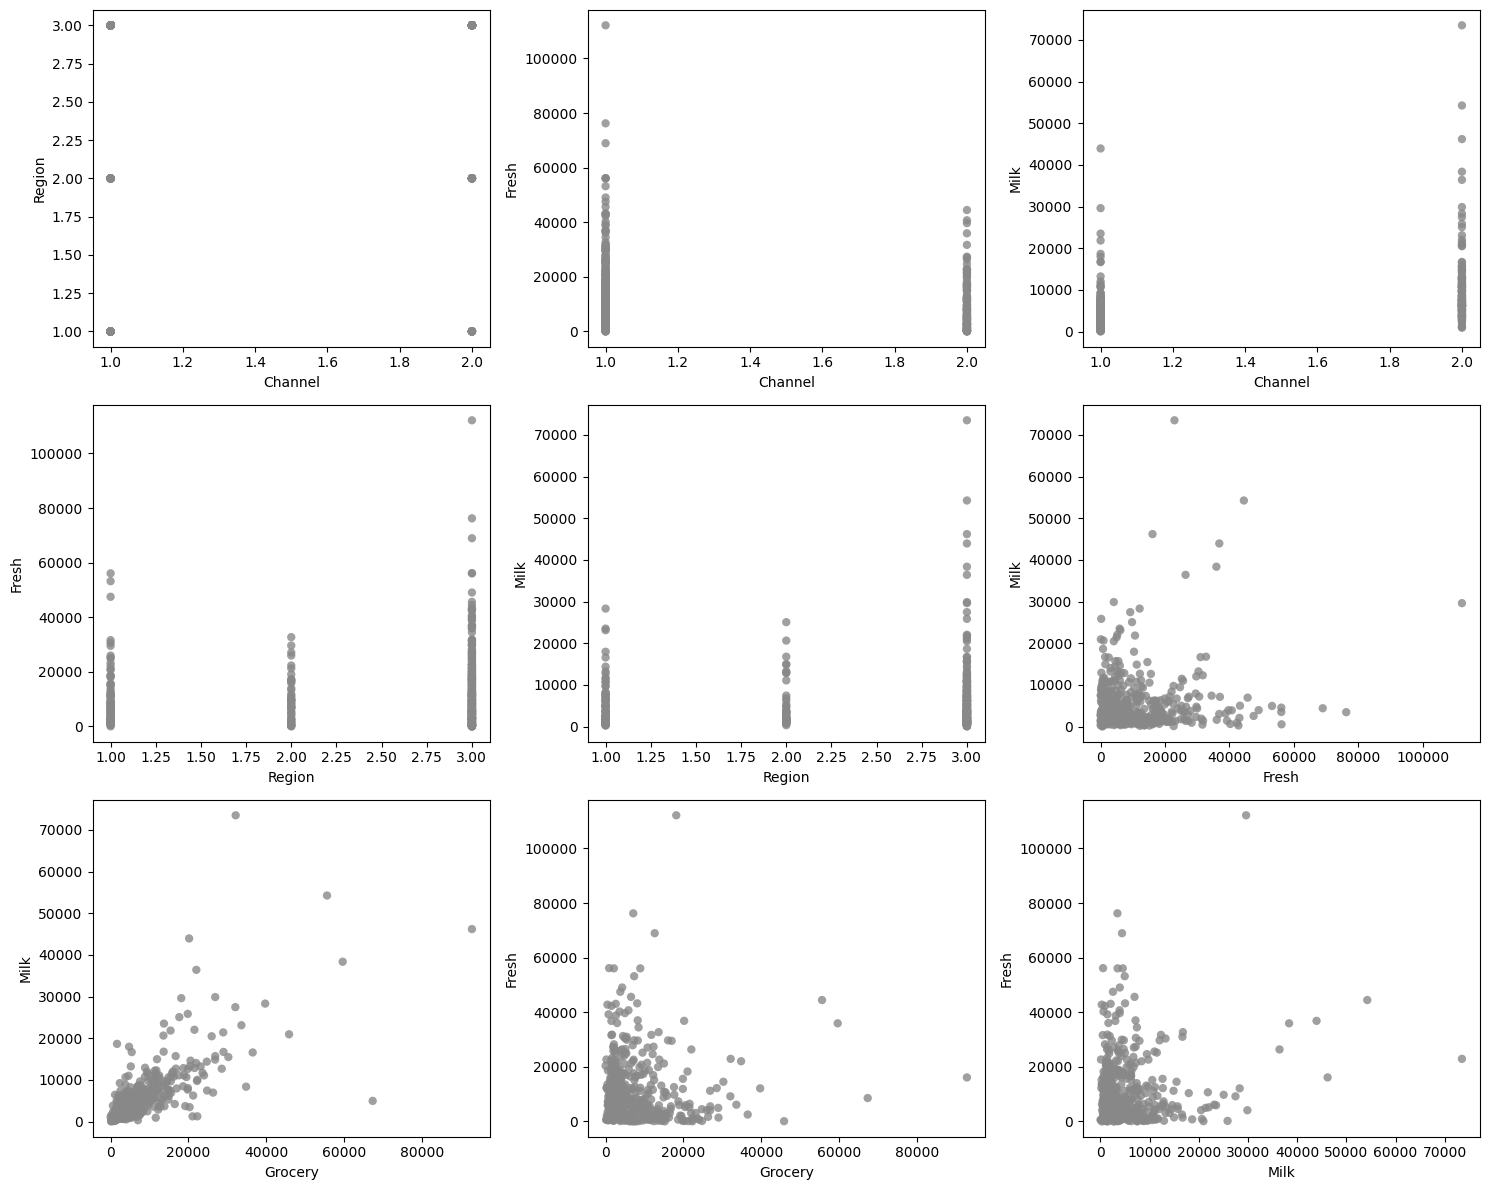

In [10]:
clust_colors_def = numpy.array(["#1965B0", "#4EB265", "#F7F056", "#DC050C", "#7BAFDE", 
                                "#CAE0AB", "#882E72", "#EE8026", "#72190E", 
                                "#888888"])

def plot_data_vpair(ax, data, vpair, vnames, clabels=None, ccenters=None, map_clabels=None, clust_colors=None):
    if clust_colors is None:
       clust_colors = clust_colors_def
    ax.set_xlabel(vnames[vpair[0]])
    ax.set_ylabel(vnames[vpair[1]])
    if clabels is not None:
        ax.scatter(data[:,vpair[0]], data[:,vpair[1]], c=clust_colors[clabels], edgecolors="none", alpha=0.8)
    else:
        ax.scatter(data[:,vpair[0]], data[:,vpair[1]], c=clust_colors[-1], edgecolors="none", alpha=0.8)
    if ccenters is not None:
        ax.scatter(ccenters[:,vpair[0]], ccenters[:,vpair[1]], s=100, c=clust_colors[map_clabels[:-1]], marker="+")
    
def plot_data(data, vnames, vpairs, clabels=None, ccenters=None, map_clabels=None, clust_colors=None):
    if clust_colors is None:
       clust_colors = clust_colors_def
    natt_cols = 3
    natt_rows = int(numpy.ceil(len(vpairs)/natt_cols))
    figsize=(15, 4*natt_rows)

    fig, axg = plt.subplots(natt_rows, natt_cols, figsize=figsize)
    axes = axg.flatten()
    for i, (xi, yi) in enumerate(vpairs):
        plot_data_vpair(axes[i], data, (xi, yi), vnames, clabels, ccenters, map_clabels, clust_colors)
        
    plt.tight_layout()
    
plot_data(X, vnames6v, vpairs6v)

As we've already seen at the description of the dataset, we can now also see in the plots that the two attributes region and channel only have a few values (because they are categorical). This allows for interesting analysis later on, so we will keep all attributes for our analysis.

Now we are ready to start clustering our data... 

## Clustering with $k$-means

We start the clustering comparison with the $k$-means algorithm. We specify the number of clusters to $k=4$.

In [11]:
clKM = cluster.KMeans(n_clusters=4, random_state=RS).fit(X)
clKM_labels, map_labels = relabel_clusters_size(clKM.labels_)

This numpy operation shows the sizes of the obtained clusters. The first value is zero as it indicates the number of outliers and there are no outliers in K-means (every data point is assigned to a cluster).

In [12]:
numpy.bincount(clKM_labels+1)

array([  0, 276,  95,  58,  11], dtype=int32)

A plot shows the different clusters, including a cross per cluster that resembles the centroid.

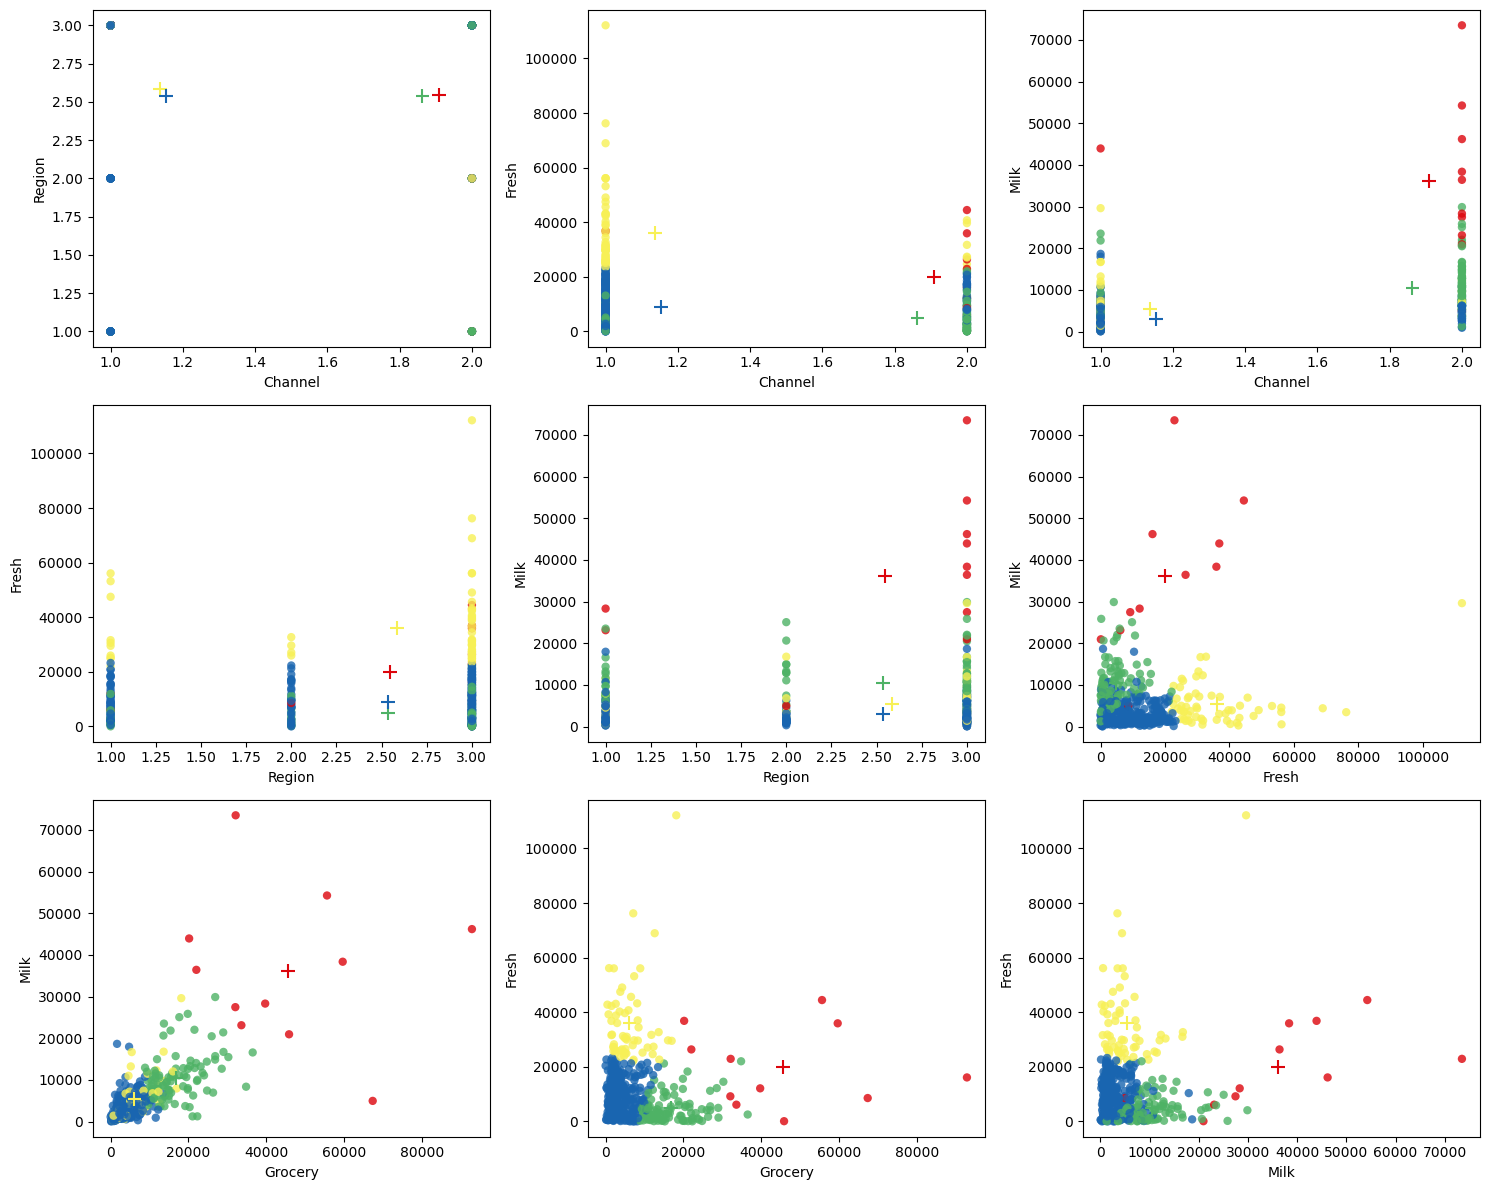

In [13]:
plot_data(X, vnames6v, vpairs6v, clKM_labels, clKM.cluster_centers_, map_labels)

Clearly, some scaling issues can be observed. Variables measured over a larger scale take over the other variables. 

To resolve it, we normalize the dataset in the next step:

In [14]:
Xn6v = numpy.vstack([(X[:,i]-numpy.min(X[:,i]))/(numpy.max(X[:,i])-numpy.min(X[:,i])) for i in range(X.shape[1])]).T

Then, the $k$-means algorithm is run again, on the normalized dataset, with k=4. 

In [15]:
clKMn6v4 = cluster.KMeans(n_clusters=4, random_state=RS).fit(Xn6v)
clKMn6v4_labels, map_labels = relabel_clusters_size(clKMn6v4.labels_)
numpy.bincount(clKMn6v4_labels+1)

array([  0, 211, 105,  87,  37], dtype=int32)

Again, we plot the data, showing the new clusters.

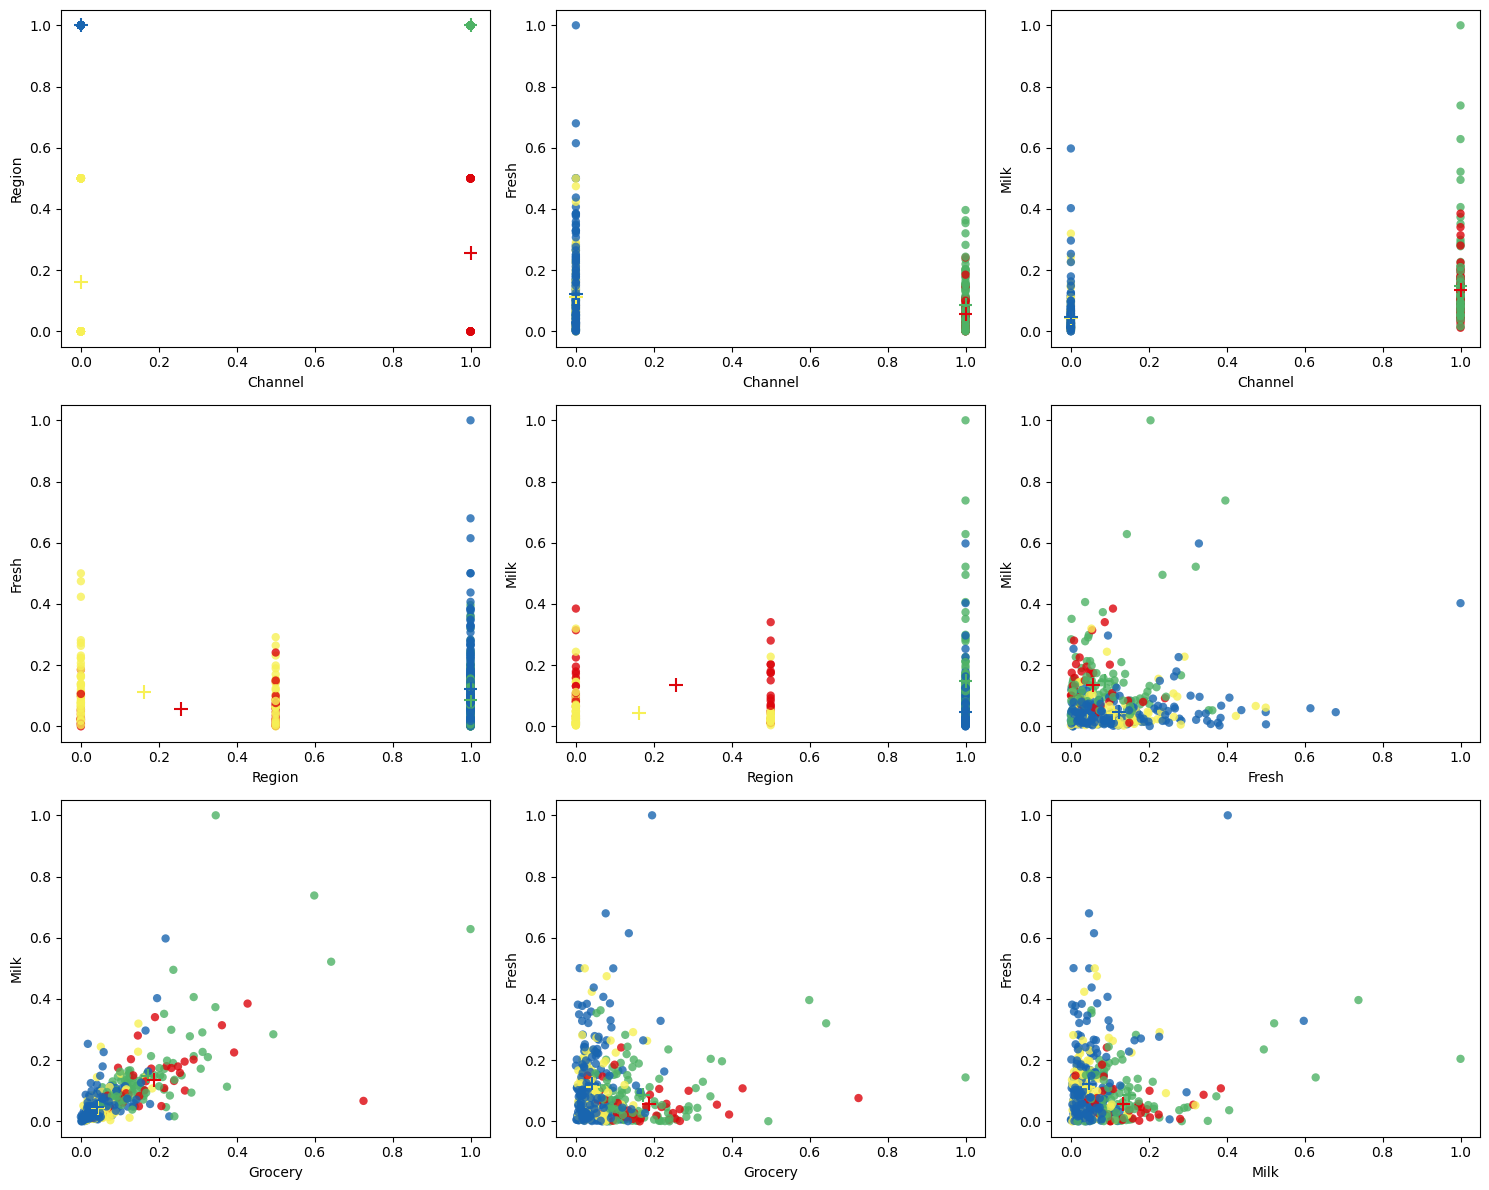

In [16]:
plot_data(Xn6v, vnames6v, vpairs6v, clKMn6v4_labels, clKMn6v4.cluster_centers_, map_labels)

Next, the clusters obtained by using the unscaled data are compared to the ones we got from the normalized data. 

To do that, we will compute the contingency matrix. Given two clusterings $\mathcal{A} = \{A_1, A_2, \dots\}$ and $\mathcal{B} = \{B_1, B_2, \dots\}$, i.e. two different partitions of the data, this matrix records for each pair of clusters $(A_i, B_j)$ the number of data points shared by the two clusters.

In [17]:
def make_contingency_matrix(labelsA, labelsB):
    ulblA = numpy.unique(labelsA)
    ulblB = numpy.unique(labelsB)
    C = numpy.zeros((len(ulblA), len(ulblB)), dtype=int)
    for lA, lB in zip(labelsA, labelsB):
        C[lA, lB] += 1
    return C, ulblA, ulblB

C, _, _ = make_contingency_matrix(clKM_labels, clKMn6v4_labels)
C

array([[164,  33,  70,   9],
       [  9,  58,   4,  24],
       [ 37,   7,  13,   1],
       [  1,   7,   0,   3]])

Next, we display the contingency matrix between the scatter plots of the two clusterings, including the correct labels for each. 

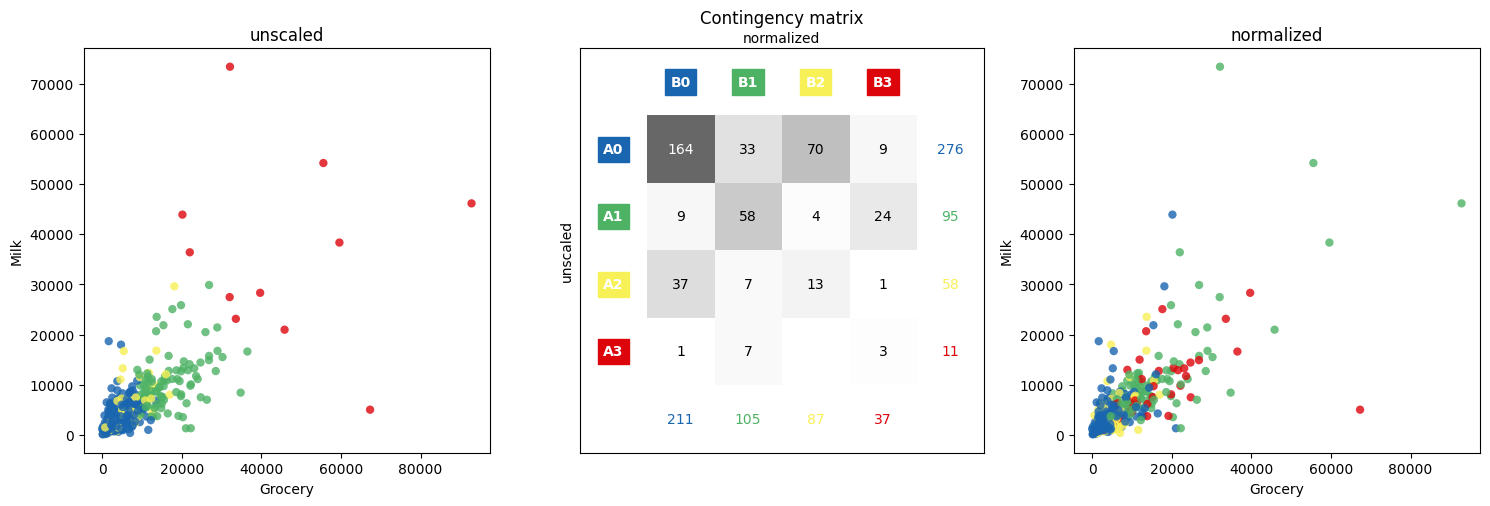

In [18]:
def plot_contingency_matrix(clabelsA, clabelsB, name_rows, name_columns, data=None, vnames=None, vpair=None, clust_colors=None):
    if clust_colors is None:
       clust_colors = clust_colors_def
    
    if not any([x is None for x in [data, vnames, vpair]]):
        with_sc = True
        fig, axg = plt.subplots(1, 3, figsize=(15,5))
        ax = axg[1]
    else:
        with_sc = False
        fig, axg = plt.subplots()
        ax = axg
    
    C, ulblA, ulblB = make_contingency_matrix(clabelsA, clabelsB)
    paddedC = numpy.zeros((C.shape[0]+2, C.shape[1]+2), dtype=int)
    paddedC[1:-1, 1:-1] = C
    marginR = numpy.sum(C, axis=1)
    marginC = numpy.sum(C, axis=0)
    vmax = numpy.maximum(numpy.max(marginC), numpy.max(marginR))

        
    im = ax.imshow(paddedC, cmap='binary', vmax = vmax)
    
    # Loop over data dimensions and create text annotations.
    for i in range(C.shape[0]):
        for j in range(C.shape[1]):
            if C[i, j] > 0.5*vmax:
                text = ax.text(j+1, i+1, C[i, j], ha="center", va="center", color="w")
            elif C[i, j] > 0:
                text = ax.text(j+1, i+1, C[i, j], ha="center", va="center", color="k")


    for i in ulblA:
        ci = i+1
        if i == -1: # outliers -> last column
            ci = len(ulblA)
        text = ax.text(0, ci, "A%d" % i, ha="center", va="center", color="w", backgroundcolor=clust_colors[i], fontweight="bold")
        text = ax.text(len(ulblB)+1, ci, marginR[i], ha="center", va="center", color=clust_colors[i])

        
    for j in ulblB:
        rj = j+1
        if j == -1: # outliers -> last row
            rj = len(ulblB)
        text = ax.text(rj, 0, "B%d" % j, ha="center", va="center", color="w", backgroundcolor=clust_colors[j], fontweight="bold")
        text = ax.text(rj, len(ulblA)+1, marginC[j], ha="center", va="center", color=clust_colors[j])

    ax.set_xlabel(name_columns)
    ax.xaxis.set_label_position('top') 
    ax.set_ylabel(name_rows)
    ax.yaxis.set_tick_params(left = False, right = False, labelleft = False)
    ax.xaxis.set_tick_params(top = False, bottom = False, labelbottom = False)
    ax.set_title("Contingency matrix")
    
    if with_sc:
        plot_data_vpair(axg[0], data, vpair, vnames, clabels=clabelsA, clust_colors=clust_colors)
        axg[0].set_title(name_rows)
        plot_data_vpair(axg[2], data, vpair, vnames, clabels=clabelsB, clust_colors=clust_colors)
        axg[2].set_title(name_columns)
     
    plt.tight_layout() 
    
plot_contingency_matrix(clKM_labels, clKMn6v4_labels, "unscaled", "normalized", X, vnames6v, vps["Grocery-Milk"]) 

Clearly, there is a big difference between the clusterings obtained with the two forms of the dataset. Let's continue using the normalized dataset for all of our operations as it will ensure we will get more accurate results.


We continue our analysis by running the $k$-means algorithm again, but this time, specifying $k=8$.

In [19]:
clKMn6v8 = cluster.KMeans(n_clusters=8, random_state=RS).fit(Xn6v)
clKMn6v8_labels, map_labels = relabel_clusters_size(clKMn6v8.labels_)
numpy.bincount(clKMn6v8_labels+1)

array([  0, 174,  98,  59,  37,  28,  18,  18,   8], dtype=int32)

When we plot the resulting clusters produced by the algorithm with their centers, we notice how difficult it is to recognize the different clusters just by looking at them.

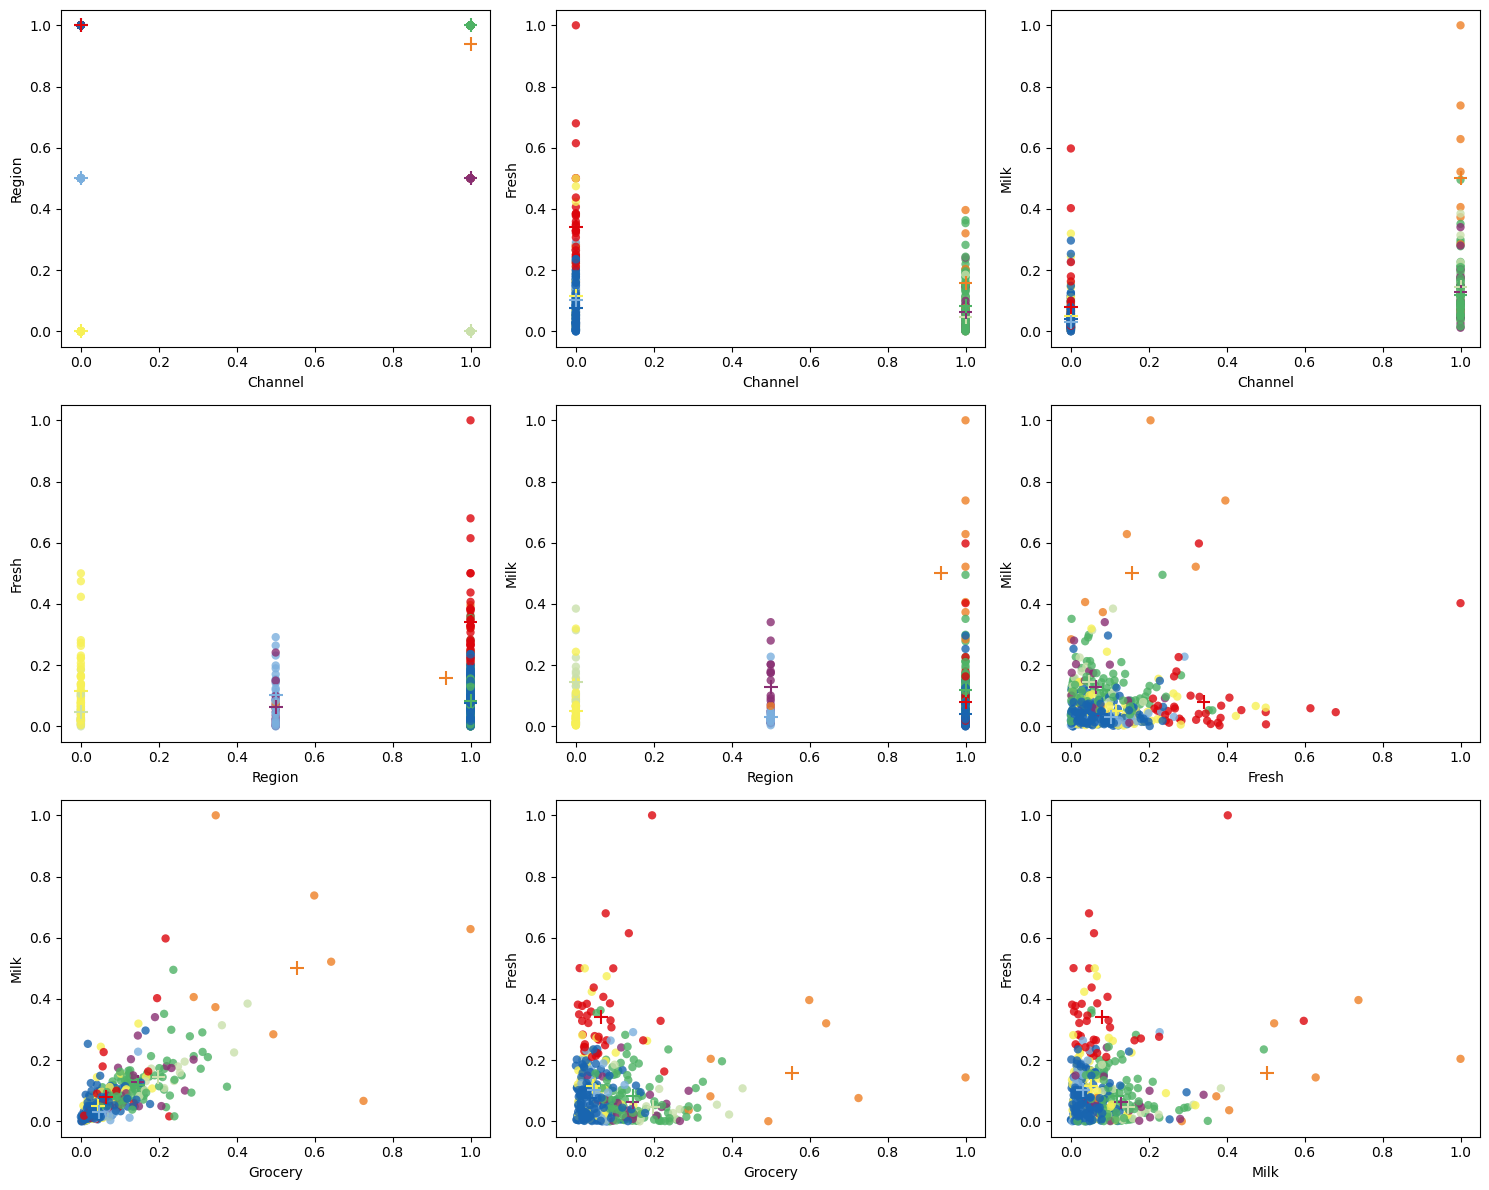

In [20]:
plot_data(Xn6v, vnames6v, vpairs6v, clKMn6v8_labels, clKMn6v8.cluster_centers_, map_labels)

We use a contingency matrix to compare the results of the $k=4$ and $k=8$ K-Means. It is no surprise that we can see a difference between the clusters produced by both algorithms, as we have increased the number of clusters by four. It is, however, a surprise that this difference is not too much. The clusters of k = 4 just split into two clusters in most cases of the k = 8 algorithm.

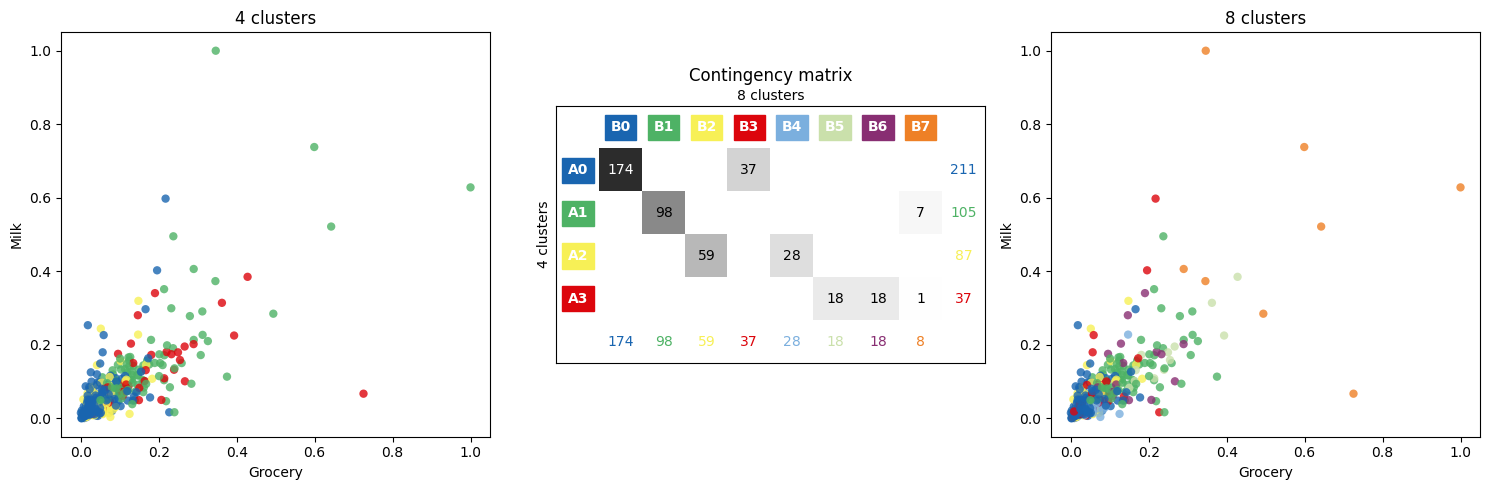

In [21]:
plot_contingency_matrix(clKMn6v4_labels, clKMn6v8_labels, "4 clusters", "8 clusters", Xn6v, vnames6v, vps["Grocery-Milk"])

The *rand score* and the *normalized mutual information score (NMI)* show how much agreement there is between the clustering produced by both algorithms. Both scores can have values between zero and one, (0: ultimate disagreement between points, 1: perfect agreement).

When we compute these values, our above finding is further supported: Both clusterings have a very high agreement.

In [22]:
metrics.rand_score(clKMn6v4_labels, clKMn6v8_labels), metrics.normalized_mutual_info_score(clKMn6v4_labels, clKMn6v8_labels)

(0.905332366949679, 0.8353796115713671)

## Clustering with bisecting $k$-means

After the K-Means algorithm, the bisecting $k$-means algorithm is applied to the dataset. It is a hierarchical top-down algorithm that applies $k$-means to  recursively bisect , i.e. split them into two. We look for eight clusters.

In [23]:
clBKMn6v8 = cluster.BisectingKMeans(n_clusters=8, random_state=RS).fit(Xn6v)
clBKMn6v8_labels, map_labels = relabel_clusters_size(clBKMn6v8.labels_)
numpy.bincount(clBKMn6v8_labels+1)

array([  0, 174,  98,  59,  37,  28,  18,  18,   8], dtype=int32)

The resulting clusters and their centers are visualized in a plot.

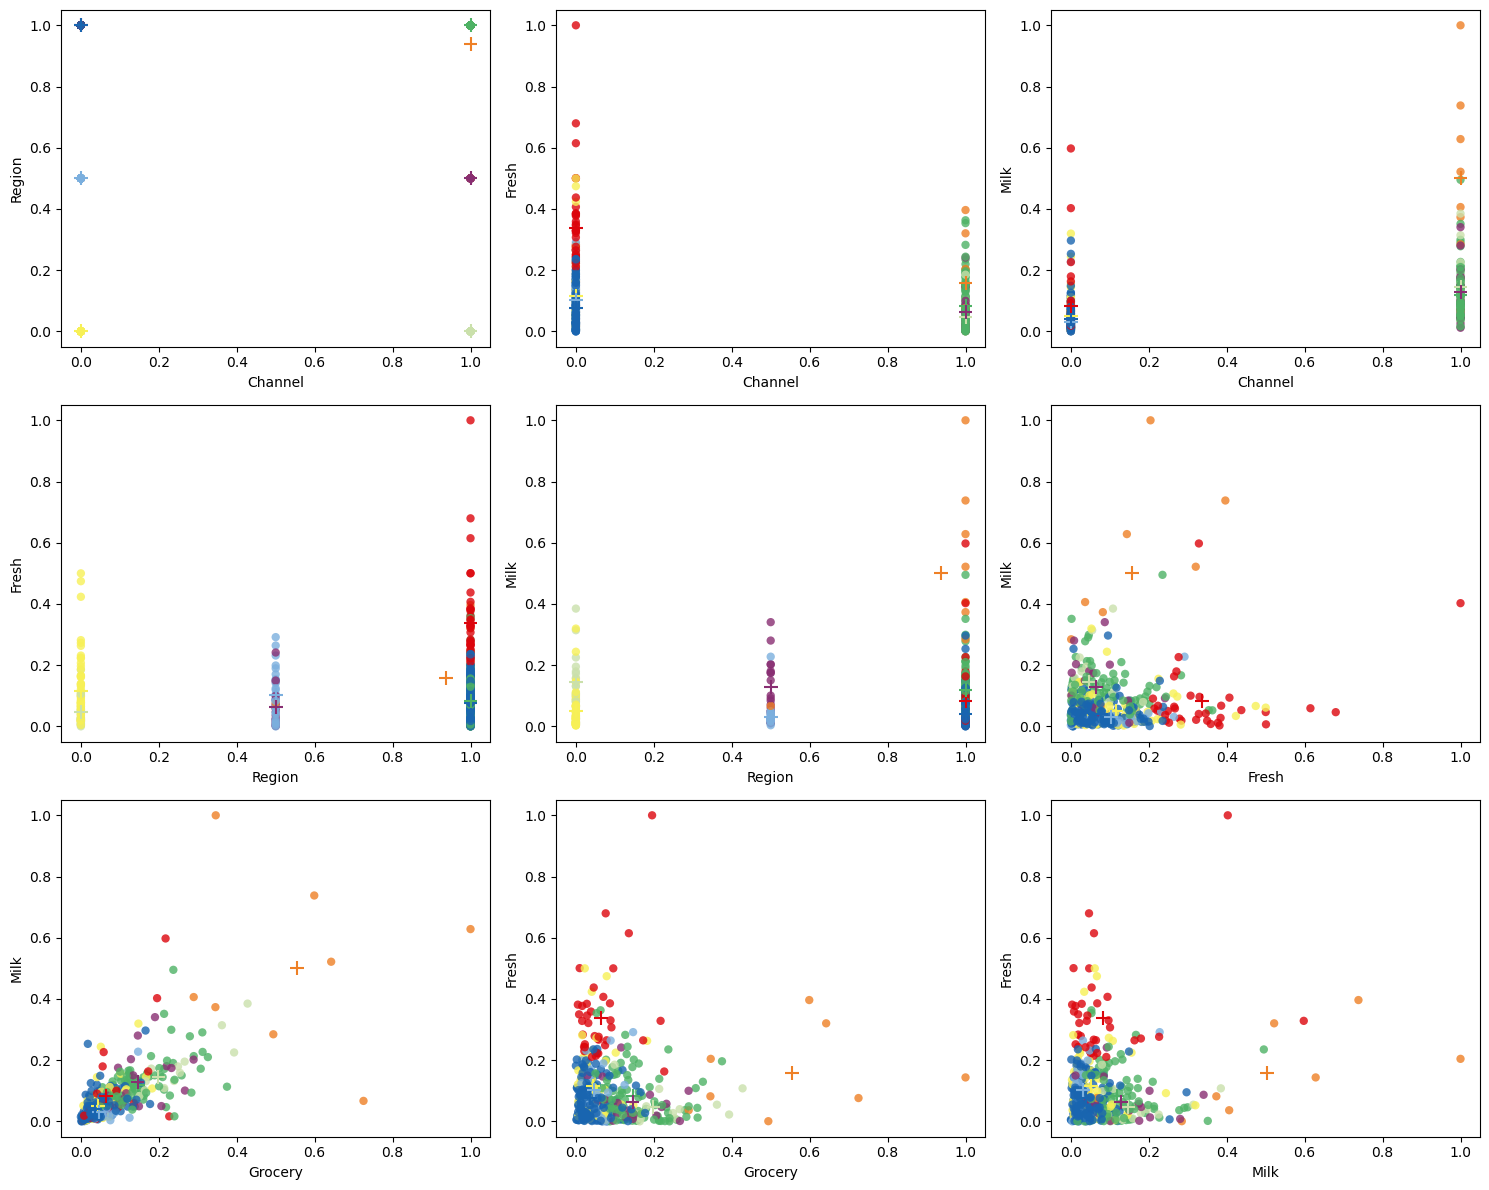

In [24]:
plot_data(Xn6v, vnames6v, vpairs6v, clBKMn6v8_labels, clBKMn6v8.cluster_centers_, map_labels)

We use a contingency matrix again to compare the results obtained by both clustering methods ($k$-means and bisecting $k$-means).

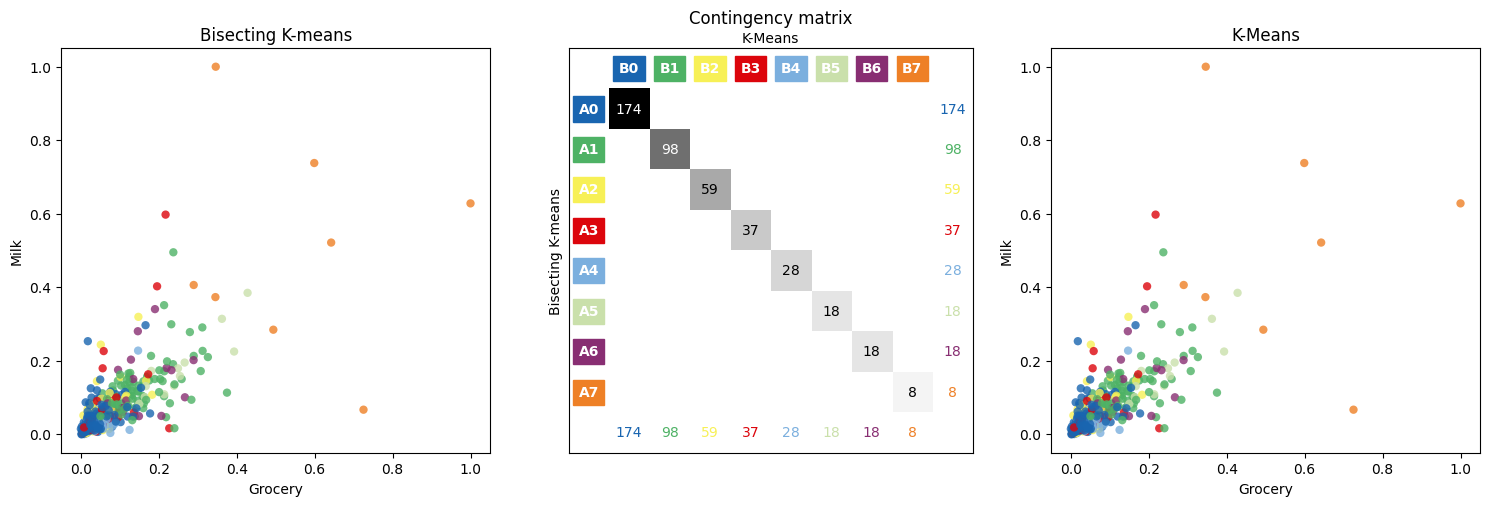

In [25]:
plot_contingency_matrix(clBKMn6v8_labels, clKMn6v8_labels, "Bisecting K-means", "K-Means", Xn6v, vnames6v, vps["Grocery-Milk"])

This finding is really interesting. Both algorithms found the EXACT same clusters! We haven't seen something like this in the Beans Notebook at all. For our analysis, it means that it doesn't matter which one of the two algorithms we choose for comparisons with other algorithms, as they have the same results. Of course, this only applies to this specific version of the algorithms with k = 8. 

As expected when we see the above matrix, our computed rand and Normalized Mutual Information score are optimal (both are 1.0), which shows the perfect agreement between both clusters.

In [26]:
metrics.rand_score(clBKMn6v8_labels, clKMn6v8_labels), metrics.normalized_mutual_info_score(clBKMn6v8_labels, clKMn6v8_labels)

(1.0, 1.0)

## Clustering with agglomerative methods

Next we continue with hierachical methods, but bottom-up, i.e. agglomerative methods that work by progressively merging data points. 

The dendrogram is a useful visual representation of the resulting hierarchy of mergers.
So first, we need a function that plots the dendrogram corresponding to an agglomerative clustering.

   - https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html
   - https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.dendrogram.html

In [27]:
from scipy.cluster.hierarchy import dendrogram
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = numpy.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = numpy.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    if "link_color_func" not in kwargs:
        kwargs["link_color_func"] = lambda k: "#888888"
    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)
    

Different approaches are obtained by considering different ways to compute the distance between two clusters, called *linkage functions*.
We will consider in turn *complete linkage*, *single linkage*, *average linkage* and *Ward linkage*.

### Complete linkage

*Complete linkage* is a clustering method which defines the distance between two sets of points to be the maximum distance between any pair of points they contain.

A dendogram is used to depicit this merging process from individual data points to a single cluster containing all data points. The algorithm is applied without specifying a number of clusters and by setting the distance threshold to zero.

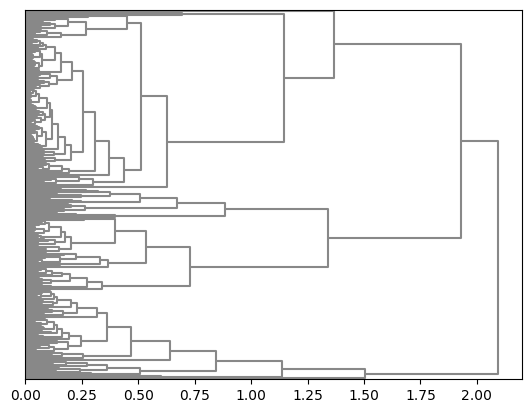

In [28]:
model = cluster.AgglomerativeClustering(linkage="complete", distance_threshold=0, n_clusters=None).fit(Xn6v)
plot_dendrogram(model, orientation='right', truncate_mode="level", p=100, no_labels=True)

Next, the merger of the last eight clusters (`truncate_mode="lastp", p=8`) into a single one is shown by zooming in into the dendrogram.

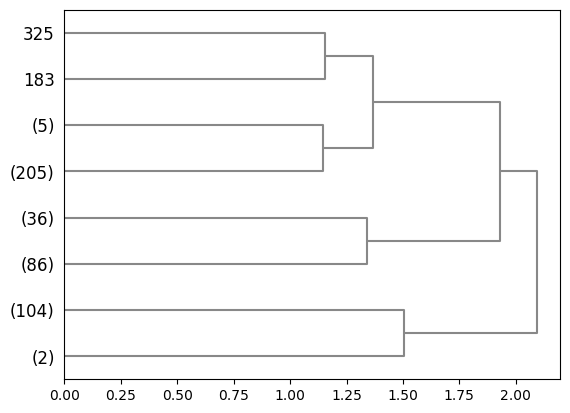

In [29]:
plot_dendrogram(model, orientation='right', truncate_mode="lastp", p=8)

This corresponds to the clusters obtained when setting the number of clusters to eight.

In [30]:
clACn6v8 = cluster.AgglomerativeClustering(linkage="complete", n_clusters=8).fit(Xn6v)
clACn6v8_labels, map_labels = relabel_clusters_size(clACn6v8.labels_)
numpy.bincount(clACn6v8_labels+1)

array([  0, 205, 104,  86,  36,   5,   2,   1,   1], dtype=int32)

We plot the resulting clusters.

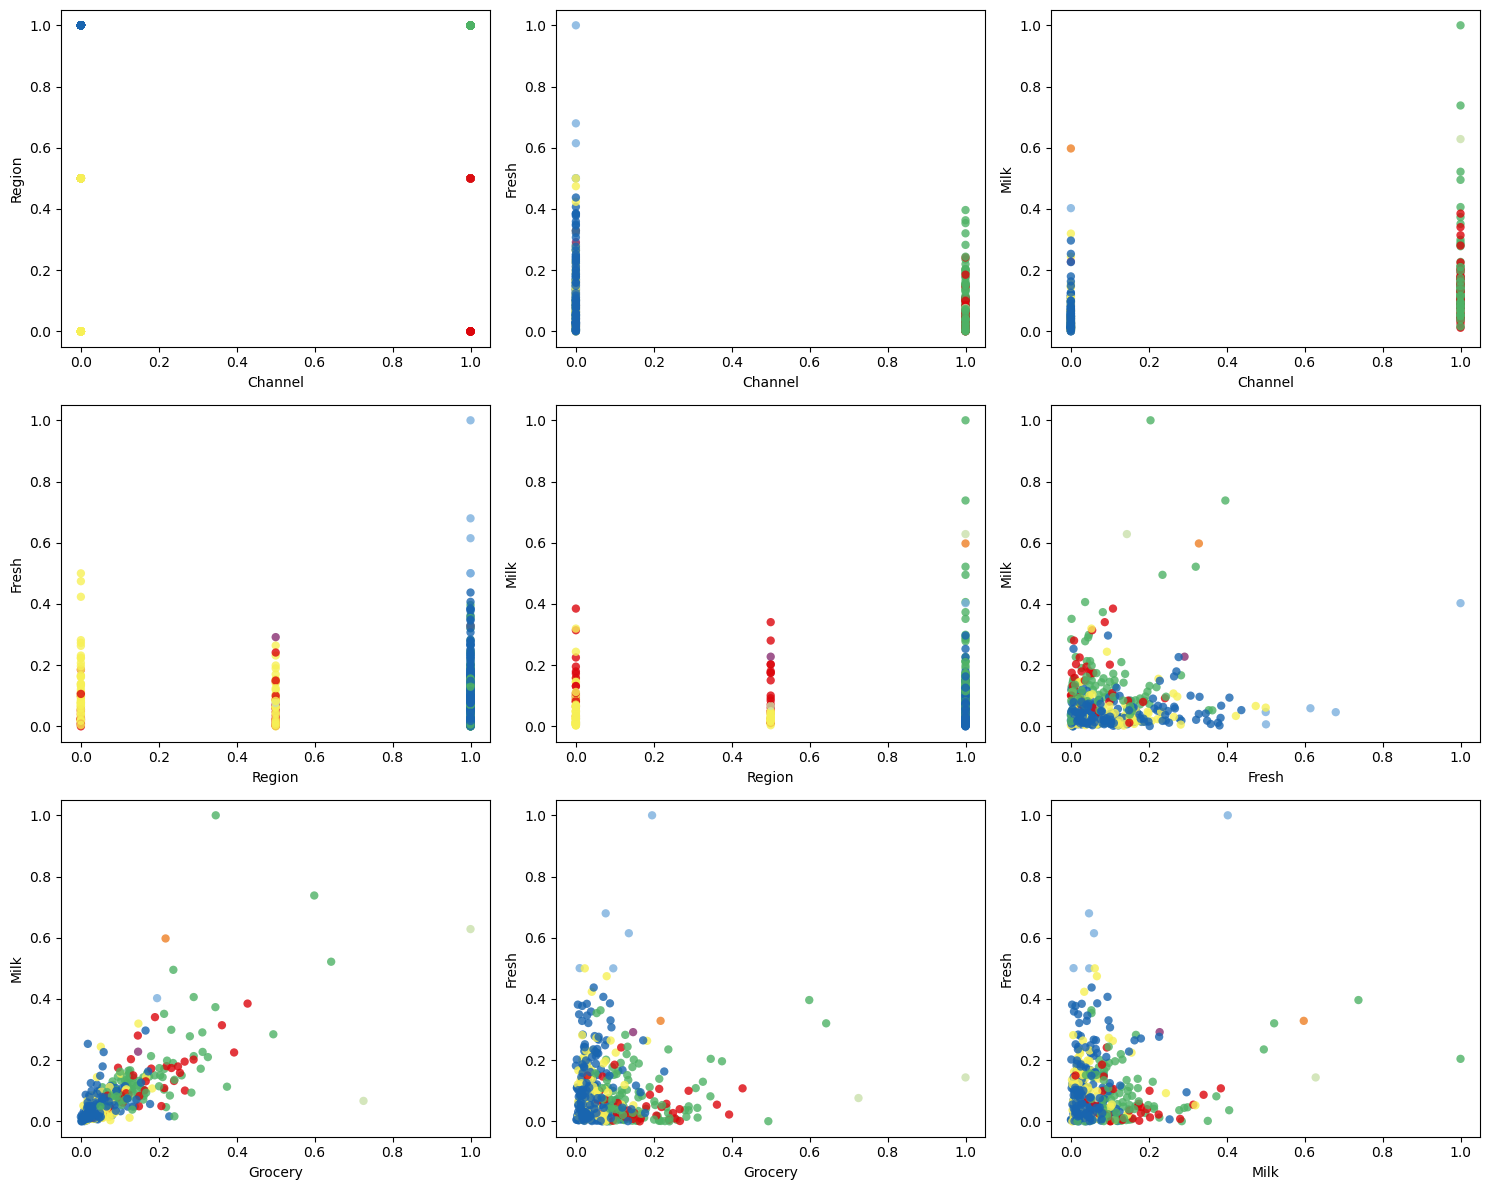

In [31]:
plot_data(Xn6v, vnames6v, vpairs6v, clACn6v8_labels)

Let's compare these results to the K-means k = 8 results:

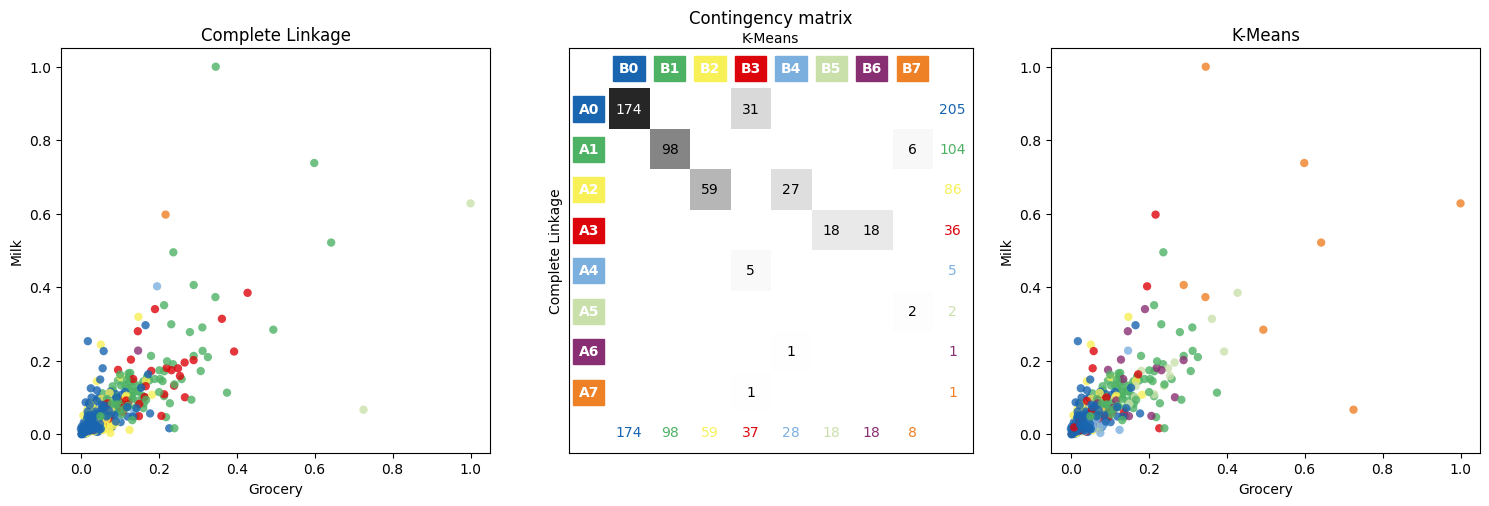

In [32]:
plot_contingency_matrix(clACn6v8_labels, clKMn6v8_labels, "Complete Linkage", "K-Means", Xn6v, vnames6v, vps["Grocery-Milk"])

The contingency matrix shows that both clusterings are quite similar, with only few differneces. WHen we compute the rand and NMI scores, we see that both clusterings have a very high agreement with each other. For all algorithms we've used so far, we always had a very good performance on these two scores when comparing them to others.

In [33]:
metrics.rand_score(clACn6v8_labels, clKMn6v8_labels), metrics.normalized_mutual_info_score(clACn6v8_labels, clKMn6v8_labels)

(0.9158314350797266, 0.8367277466847938)

We then computed the NMI scores and rand scores of the bisecting K-Means and the Complete Linkage clusters, to show once again that the K-Means and Bisecting K-Means can be used instead of each other with their given configuration in this dataset (because they have the same results):

In [34]:
metrics.rand_score(clBKMn6v8_labels, clACn6v8_labels), metrics.normalized_mutual_info_score(clBKMn6v8_labels, clACn6v8_labels)

(0.9158314350797266, 0.8367277466847938)

### Single linkage

*Single linkage* defines the distance between two sets of points to be the minimum distance between any pair of points they contain. Again, we use a dendogram to visualize it.

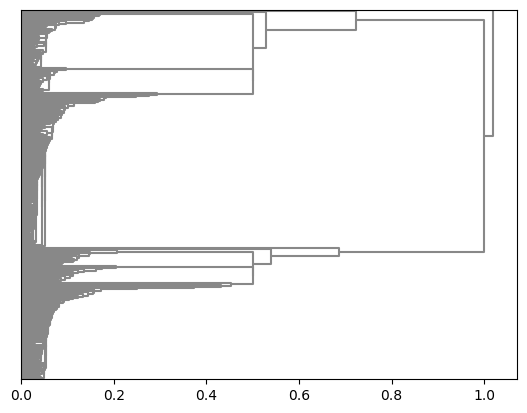

In [35]:
model = cluster.AgglomerativeClustering(linkage="single", distance_threshold=0, n_clusters=None).fit(Xn6v)
plot_dendrogram(model, orientation='right', truncate_mode="level", p=100, no_labels=True)

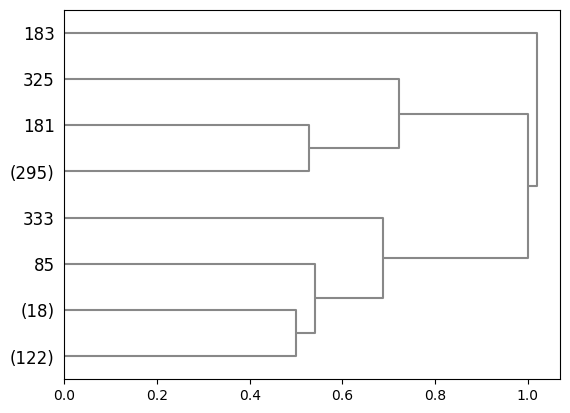

In [36]:
plot_dendrogram(model, orientation='right', truncate_mode="lastp", p=8)

We want to have 8 clusters again as it will be useful for our later evaluation to have the same number of clusters for every method used (except DB Scan and K-means k = 4).

In [37]:
clASn6v8 = cluster.AgglomerativeClustering(linkage="single", n_clusters=8).fit(Xn6v)
clASn6v8_labels, map_labels = relabel_clusters_size(clASn6v8.labels_)
numpy.bincount(clASn6v8_labels+1)

array([  0, 295, 122,  18,   1,   1,   1,   1,   1], dtype=int32)

And plotting them.

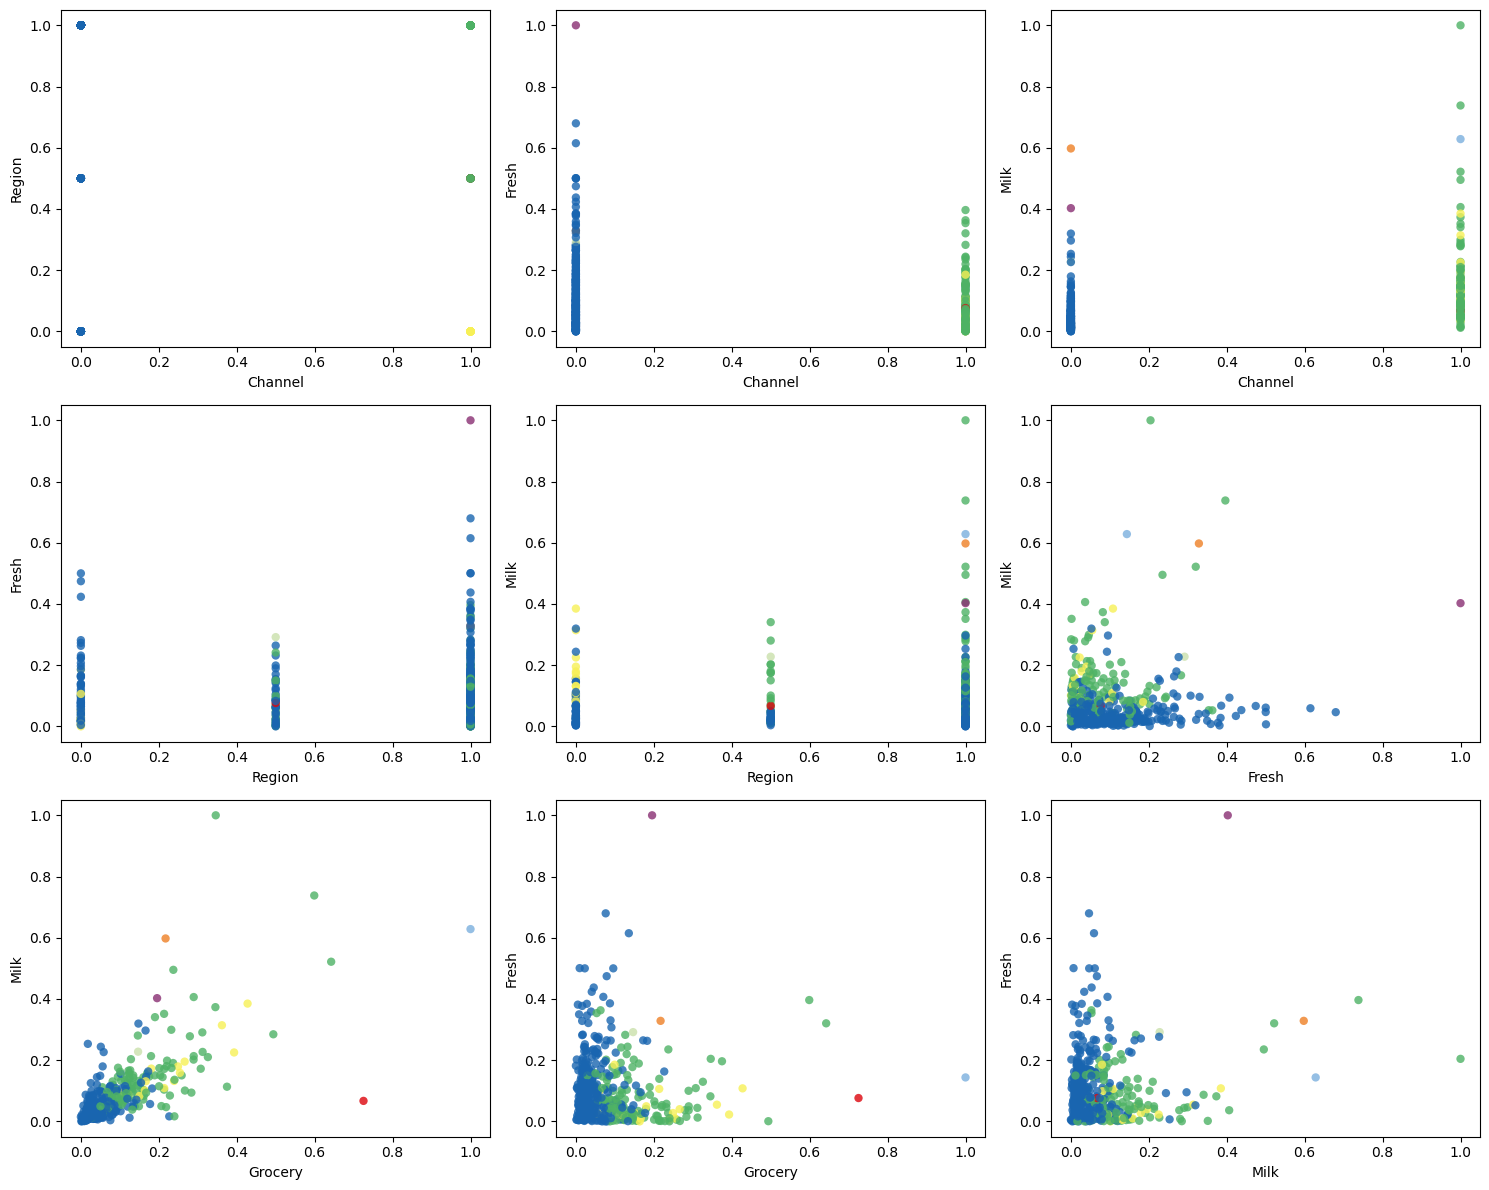

In [38]:
plot_data(Xn6v, vnames6v, vpairs6v, clASn6v8_labels)

### Average linkage

*Average linkage* describes the distance between two sets of points to be the average distance between all pairs of points they contain, as the name suggests. We start with a dendrogram again:

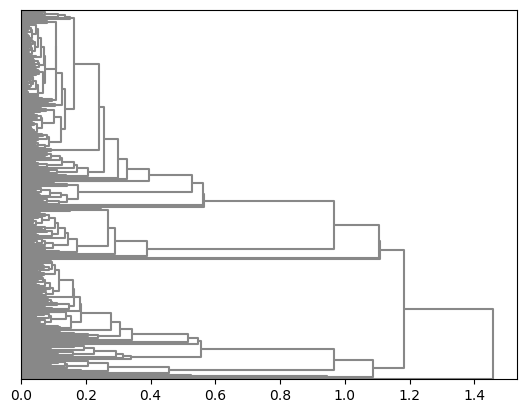

In [39]:
model = cluster.AgglomerativeClustering(linkage="average", distance_threshold=0, n_clusters=None).fit(Xn6v)
plot_dendrogram(model, orientation='right', truncate_mode="level", p=100, no_labels=True)

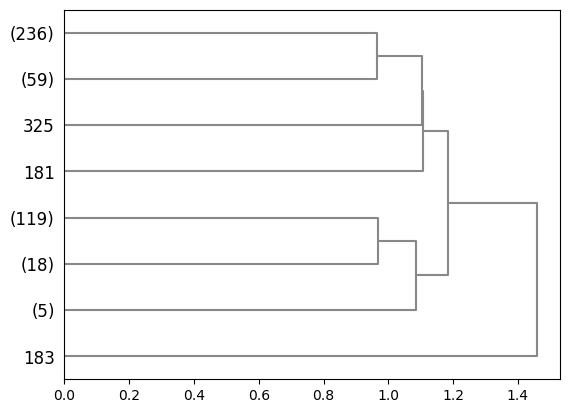

In [40]:
plot_dendrogram(model, orientation='right', truncate_mode="lastp", p=8)

Obtaining the corresponding clusters.

In [41]:
clAAn6v8 = cluster.AgglomerativeClustering(linkage="average", n_clusters=8).fit(Xn6v)
clAAn6v8_labels, map_labels = relabel_clusters_size(clAAn6v8.labels_)
numpy.bincount(clAAn6v8_labels+1)

array([  0, 236, 119,  59,  18,   5,   1,   1,   1], dtype=int32)

And plotting them.

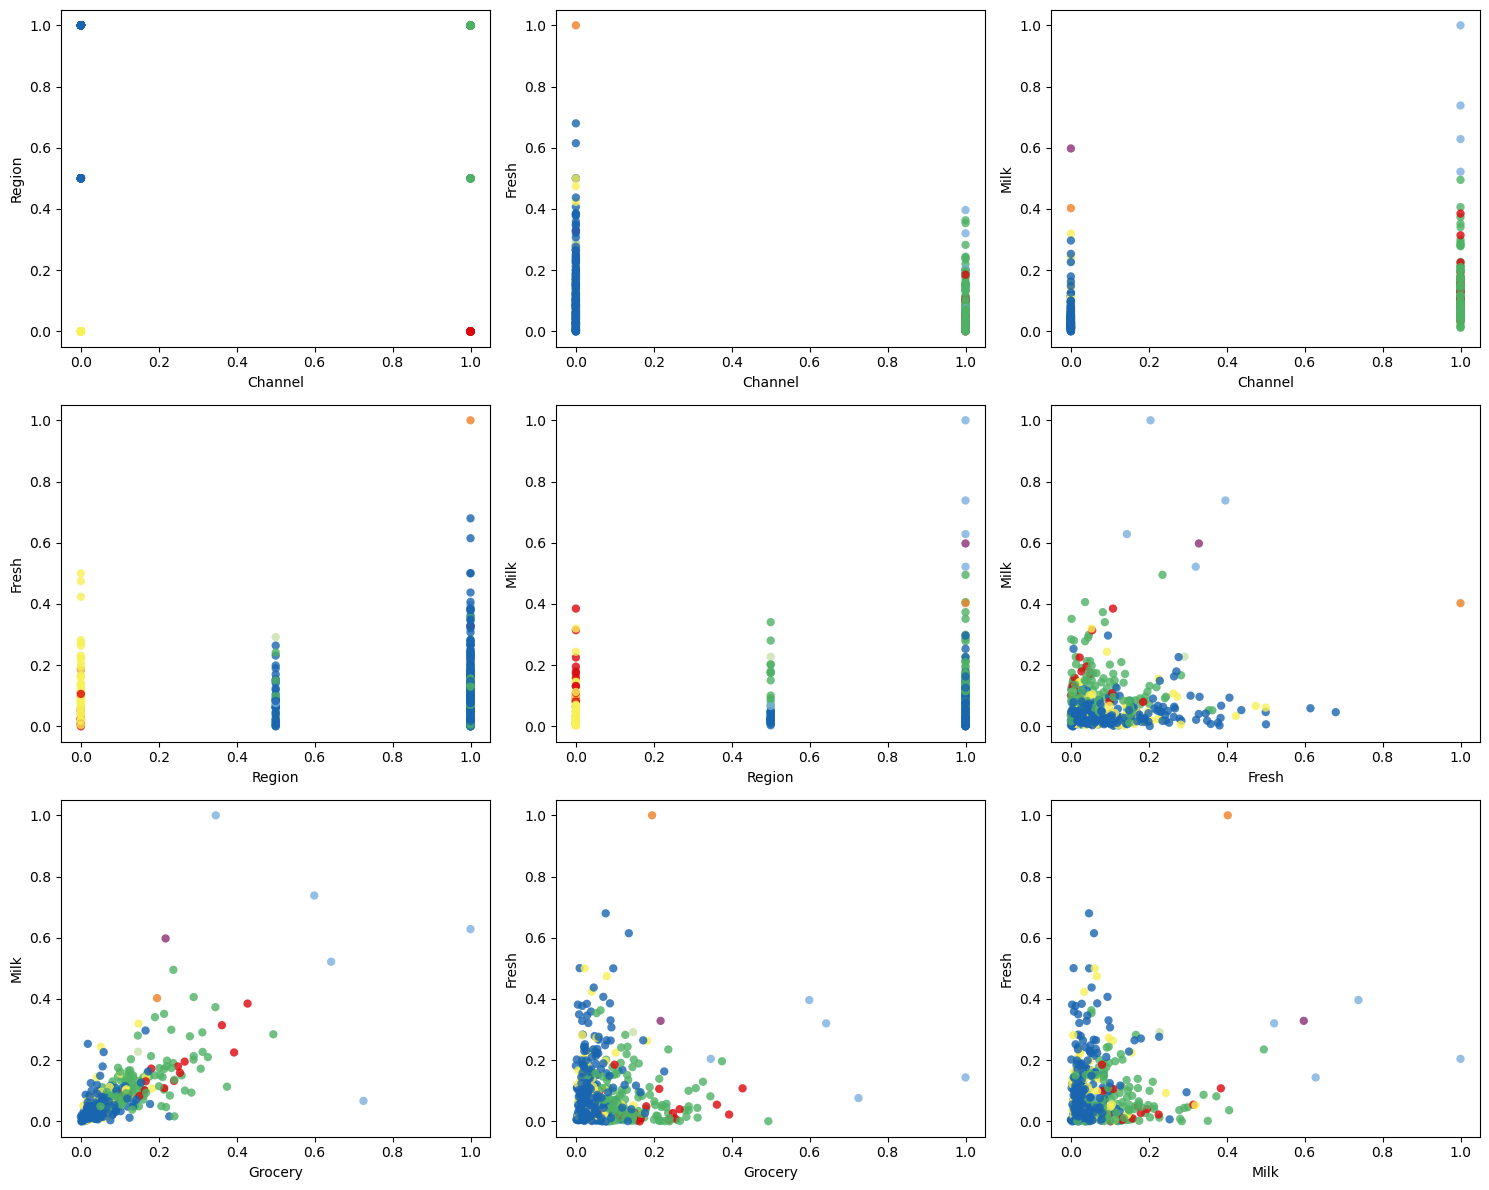

In [42]:
plot_data(Xn6v, vnames6v, vpairs6v, clAAn6v8_labels)

### Ward linkage

The last linkage function considered in this analysis is the *Ward linkage*, which corresponds to minimizing the variance of the cluster resulting from the merger.

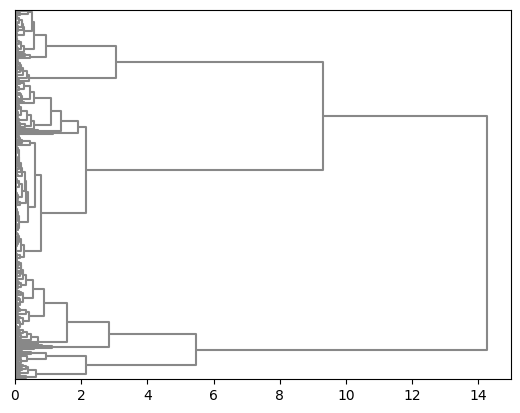

In [43]:
model = cluster.AgglomerativeClustering(linkage="ward", distance_threshold=0, n_clusters=None).fit(Xn6v)
plot_dendrogram(model, orientation='right', truncate_mode="level", p=100, no_labels=True)

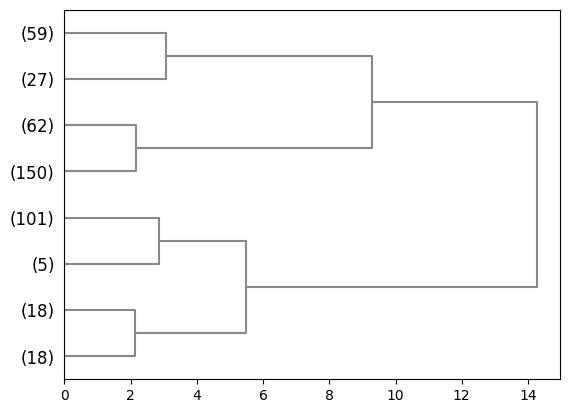

In [44]:
plot_dendrogram(model, orientation='right', truncate_mode="lastp", p=8)

Obtaining the corresponding clusters.

In [45]:
clAWn6v8 = cluster.AgglomerativeClustering(linkage="ward", n_clusters=8).fit(Xn6v)
clAWn6v8_labels, map_labels = relabel_clusters_size(clAWn6v8.labels_)
numpy.bincount(clAWn6v8_labels+1)

array([  0, 150, 101,  62,  59,  27,  18,  18,   5], dtype=int32)

And plotting them.

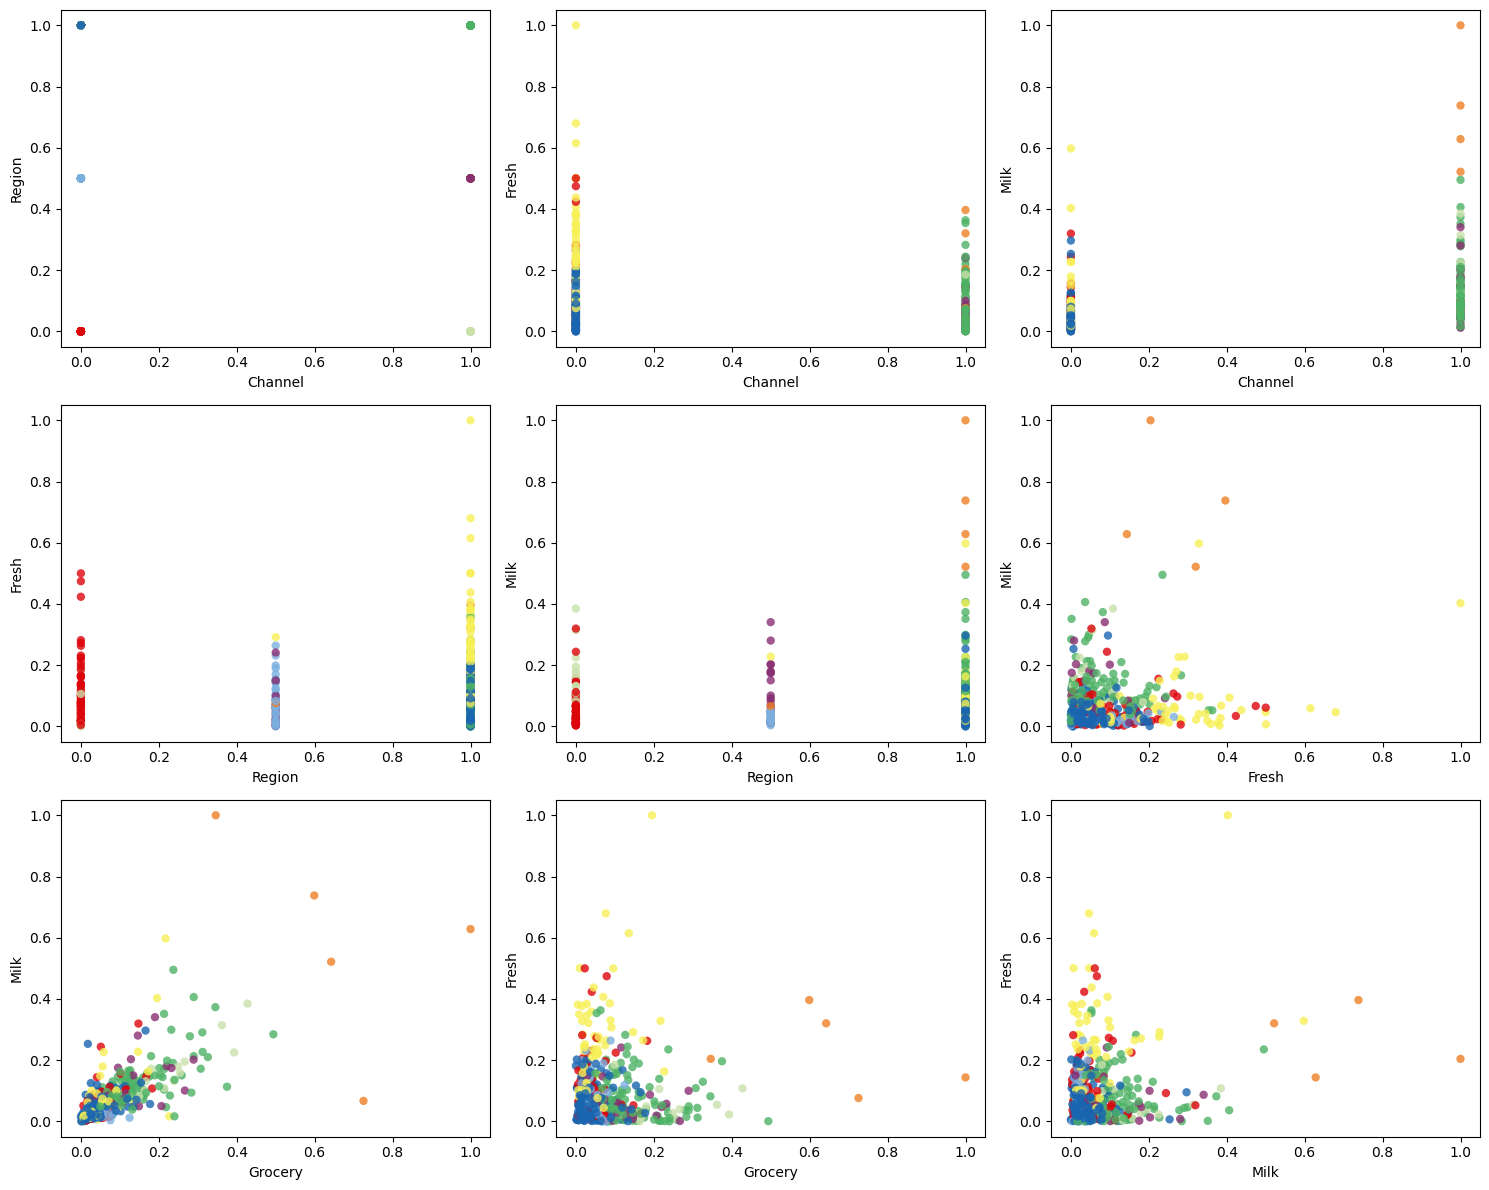

In [46]:
plot_data(Xn6v, vnames6v, vpairs6v, clAWn6v8_labels)

Let's compare this algorithm and and the other linkage functions to the previous algorithms. First, we first compare the Ward linkage clusterings to the complete linkage clusterings. Both methods clustered the data points quite similarly (A0 and B0 are even identical) and therefore, the corresponding rand and NMI scores are again quite high. 

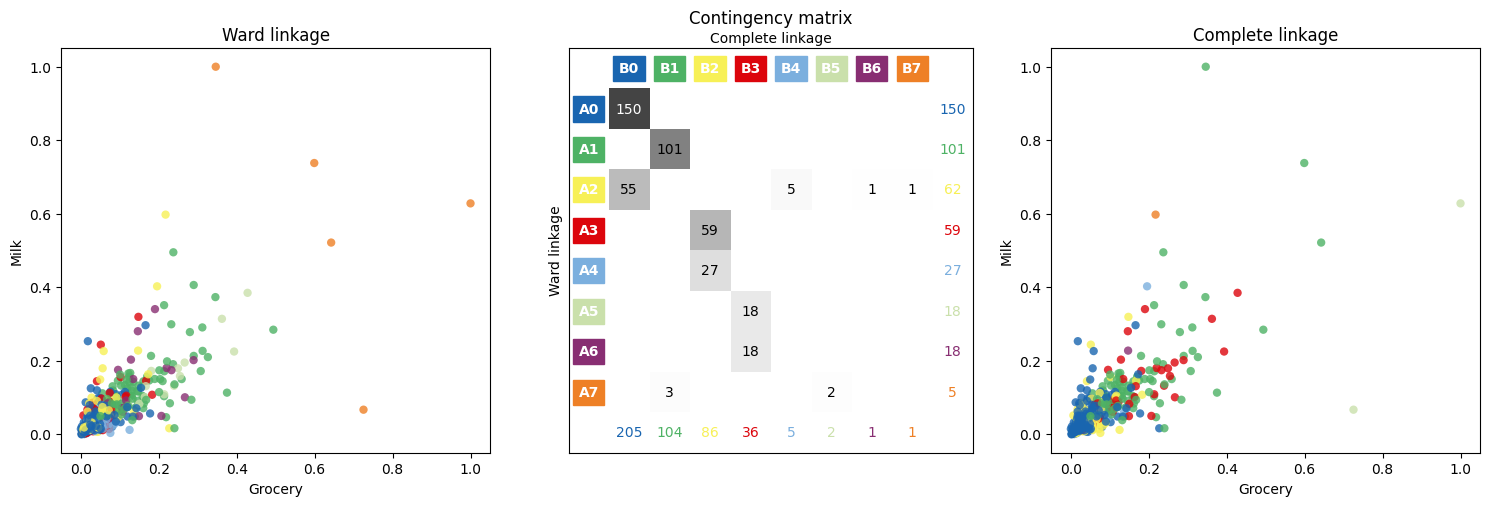

In [47]:
plot_contingency_matrix(clAWn6v8_labels, clACn6v8_labels, "Ward linkage", "Complete linkage", Xn6v, vnames6v, vps["Grocery-Milk"])

In [48]:
metrics.rand_score(clAWn6v8_labels, clACn6v8_labels), metrics.normalized_mutual_info_score(clAWn6v8_labels, clACn6v8_labels)

(0.8874301097535722, 0.820065808756094)

Next, we want to compare the single linkage to the average linkage algorithm:

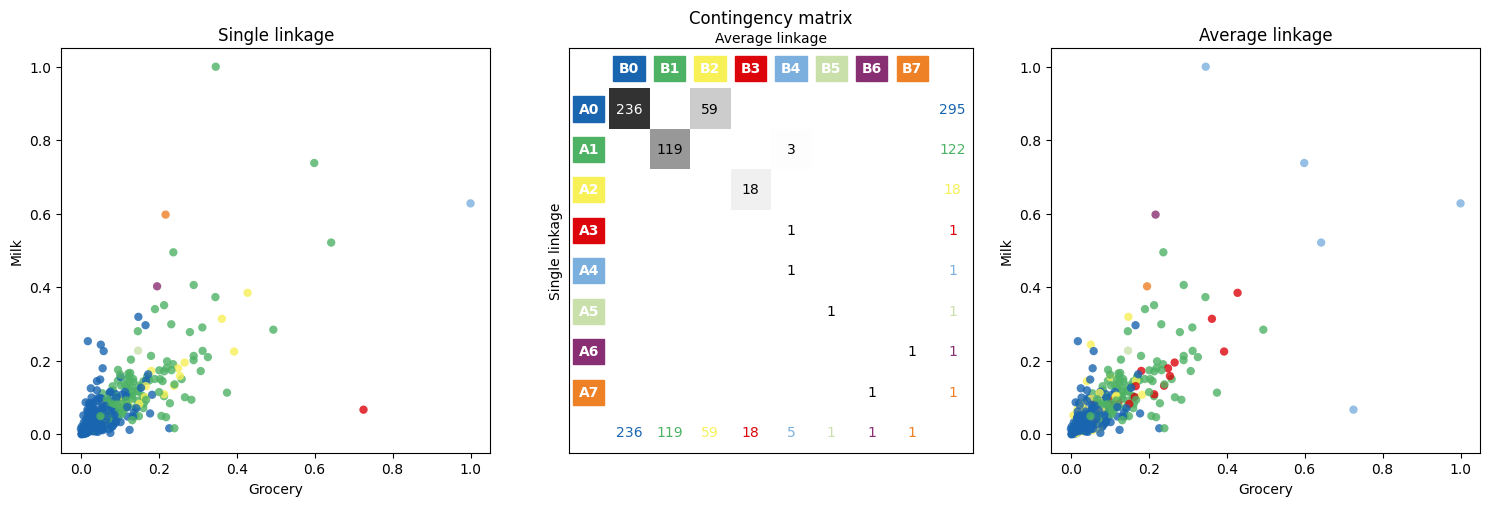

In [49]:
plot_contingency_matrix(clASn6v8_labels, clAAn6v8_labels, "Single linkage", "Average linkage", Xn6v, vnames6v, vps["Grocery-Milk"])

WHen we compare this matrix to the one above (ward linkage vs. complete linkage), we can see that the results are similarly good. We can only observe minor differences between the clusters obtained by the single and average linkage algorthms. 

In [50]:
metrics.rand_score(clASn6v8_labels, clAAn6v8_labels), metrics.normalized_mutual_info_score(clASn6v8_labels, clAAn6v8_labels)

(0.8520604680057983, 0.811230440921141)

The rand and NMI scores show what we've already seen in the matrix. The values are very close to the ones in the ward versus complete linkage analysis. They are just slightly lower in this case, but still good and showing high agreement.

## Clustering with DBSCAN

DBSCAN is a density based method for clustering data. Instead of specifying the number of clusters, the parameters epsilon and Tao will be specified at the beginning of this algorithm, so that it can determine which points are considered to be located in dense regions, forming clusters.
Another important aspect of this method is that some points in sparser regions might be considered outliers or noise and not assigned to any clusters.

When we apply this algorithm, we see it identifies 70 noise points.

In [51]:
clDBSn6v = cluster.DBSCAN(eps=0.1, min_samples=4).fit(Xn6v)
clDBSn6v_labels, map_labels = relabel_clusters_size(clDBSn6v.labels_)
numpy.bincount(clDBSn6v_labels+1)

array([ 70, 193,  86,  50,  27,   8,   6], dtype=int32)

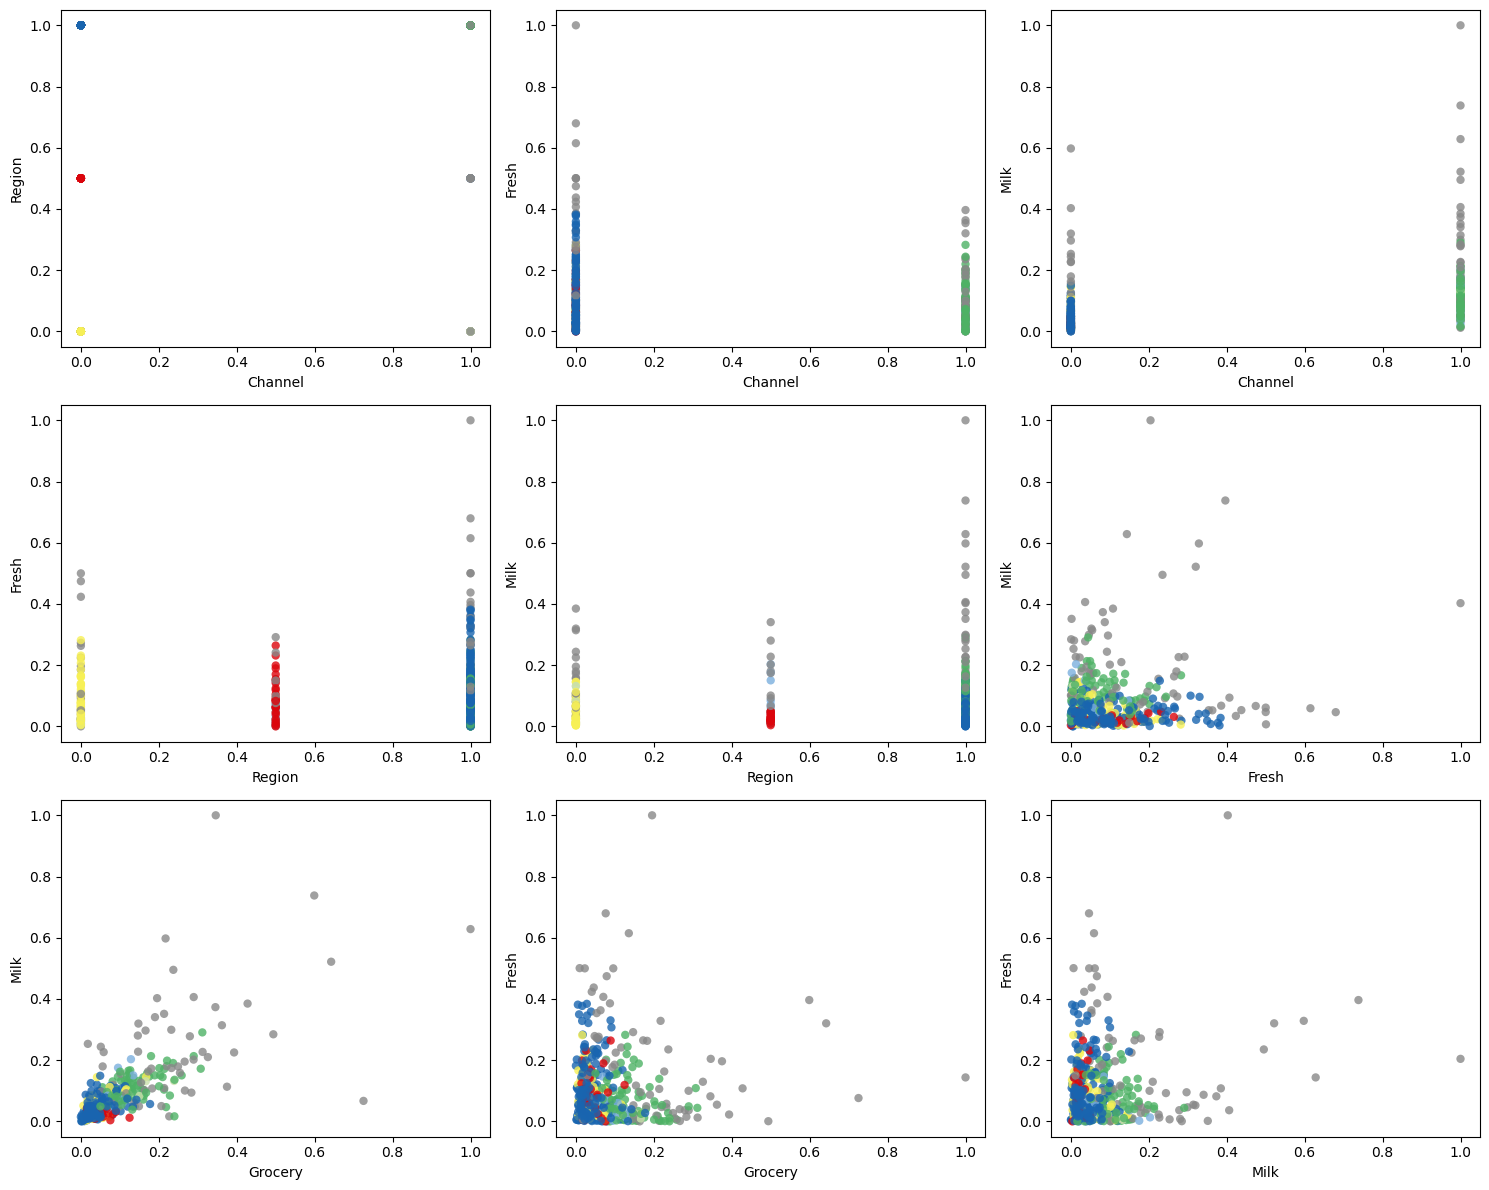

In [52]:
plot_data(Xn6v, vnames6v, vpairs6v, clDBSn6v_labels)

The clusterings from DBSCAN are compared to the clusterings of complete linkage. While the complete linkage algorithm assignes every point to a clsuter, the DB Scan algorithm also assignes 70 points to no cluster, as it identifies them as noise. Specifically, the DB Scan algorithm finds noise in every cluster of the eight clusters of the complete linkage algorithm. This leads to some differneces between both clusterings. But again, they are quite similar overall. Interestingly, the DB Scan identifies all data points in B4 to B7 as noise and thus, doesn't assign them to any cluster.

Although the DB Scan produces only 6 clusters in total, instead of 8, the clusters are still relatively similar.


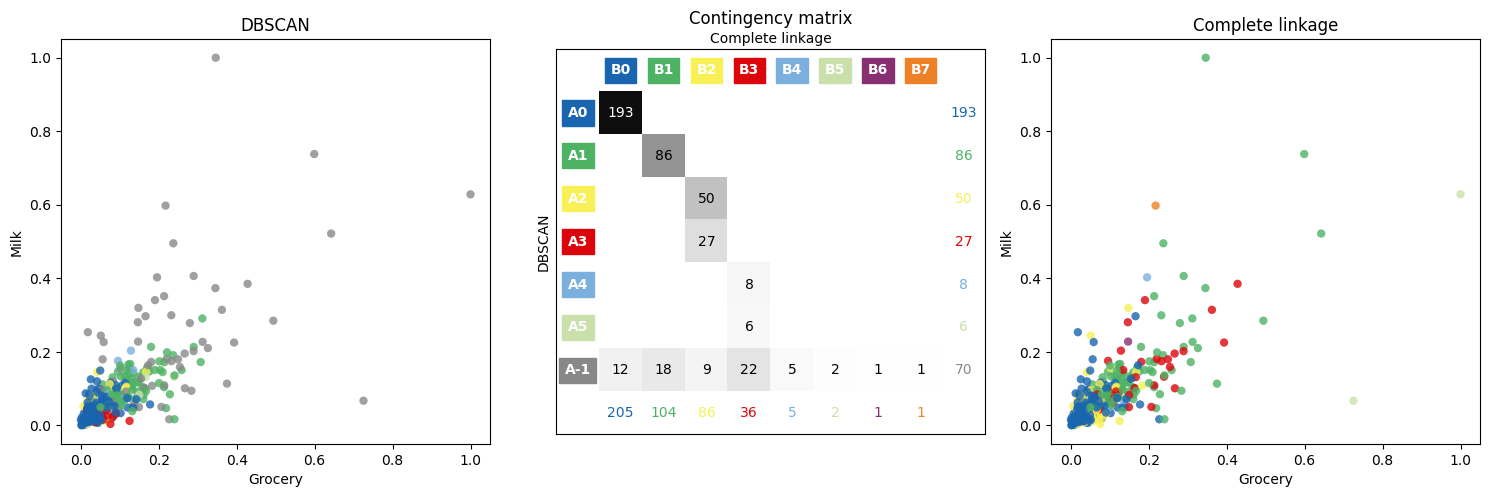

In [53]:
plot_contingency_matrix(clDBSn6v_labels, clACn6v8_labels, "DBSCAN", "Complete linkage", Xn6v, vnames6v, vps["Grocery-Milk"])

In [54]:
metrics.rand_score(clDBSn6v_labels, clACn6v8_labels), metrics.normalized_mutual_info_score(clDBSn6v_labels, clACn6v8_labels)

(0.9152930213294678, 0.7410875360477462)

The above findings are also underlined when we compute the NMI and rand score. Especially the great rand score demonstrates this high agreement between the clusters. The majority of the disagreements between both algorithms is due to the noise categorization of the the DB Scan algorithm.

Let's recompute the DB Scan using an epsilon of 0.2 to see how it will affect the algorithm:

In [55]:
clDBSn6v2 = cluster.DBSCAN(eps=0.2, min_samples=4).fit(Xn6v)
clDBSn6v2_labels, map_labels2 = relabel_clusters_size(clDBSn6v2.labels_)
numpy.bincount(clDBSn6v2_labels+1)

array([ 16, 206,  99,  59,  27,  17,  16], dtype=int32)

This change has a big effect. We can already see that the number of noise points went down to 16, after being 70 before. Likewise, the size of the individual clusters rose, as more points are assigned to a cluster. This finding makes sense. A higher epsilon leads to a lower entry barrier for points to be identified as being in a dense region.

When we plot the clustering, we see this decrease in noise points clearly too:

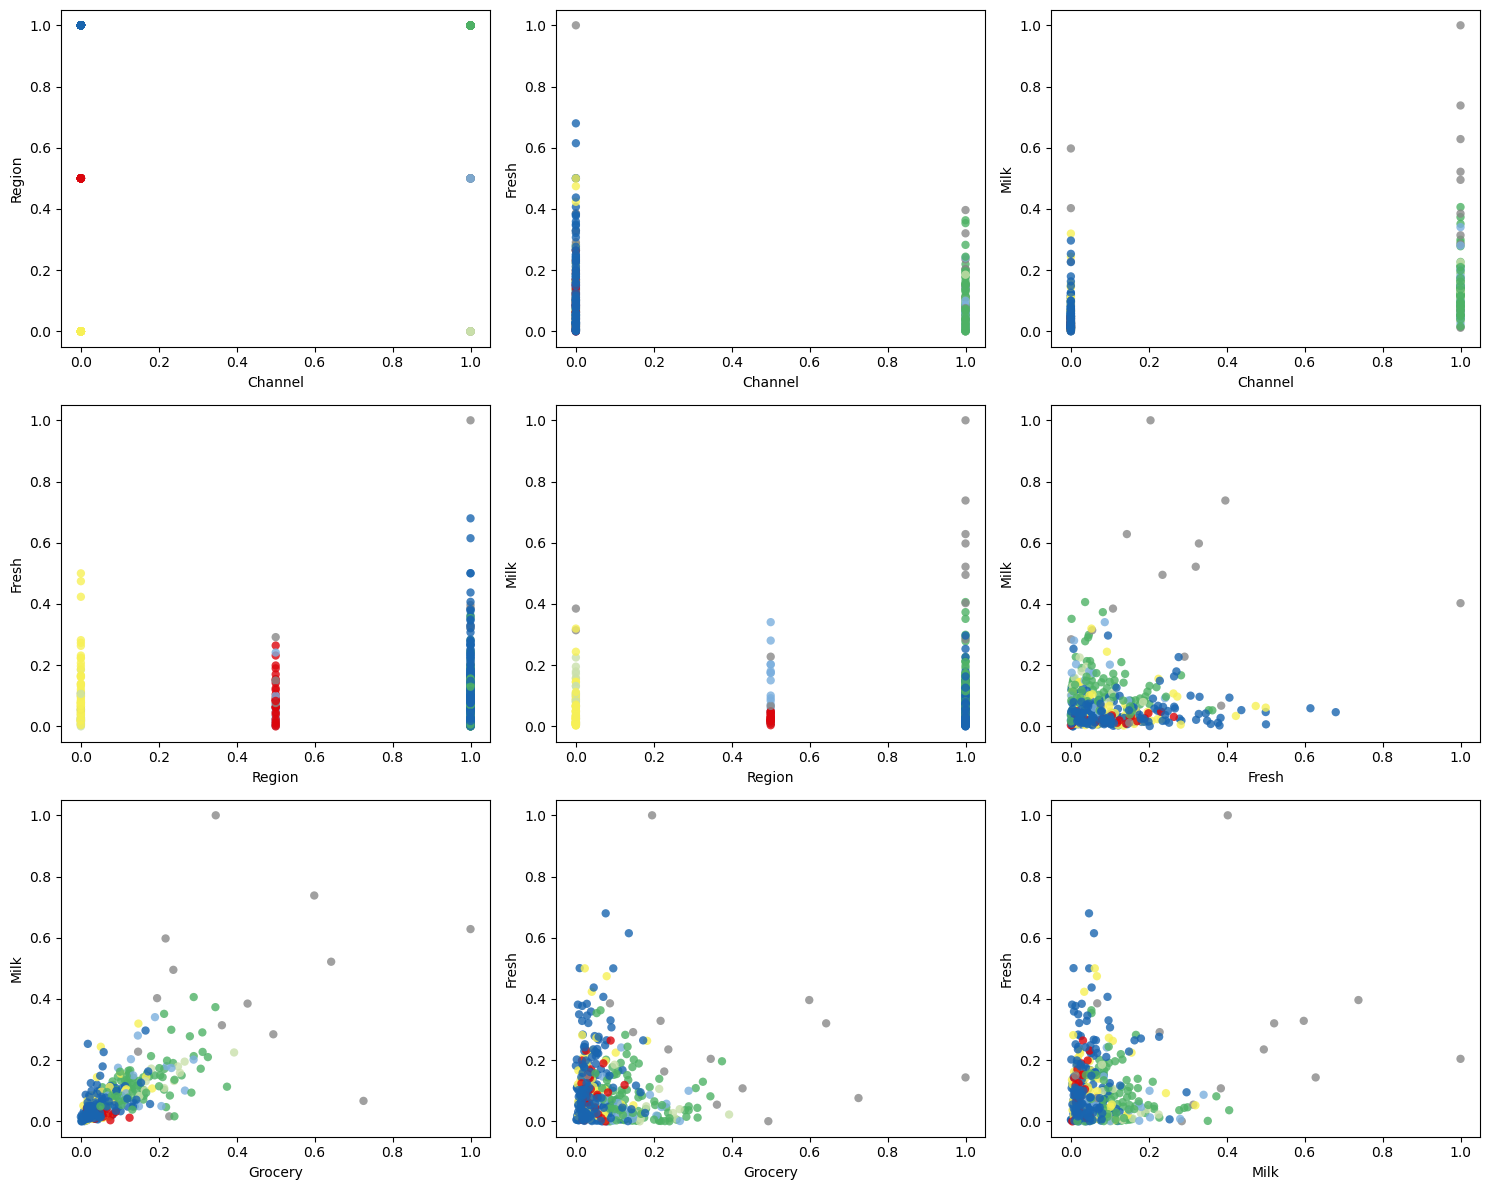

In [56]:
plot_data(Xn6v, vnames6v, vpairs6v, clDBSn6v2_labels)

Next, we compare this form of the DB Scan algorithm to the complete linkage results once again:

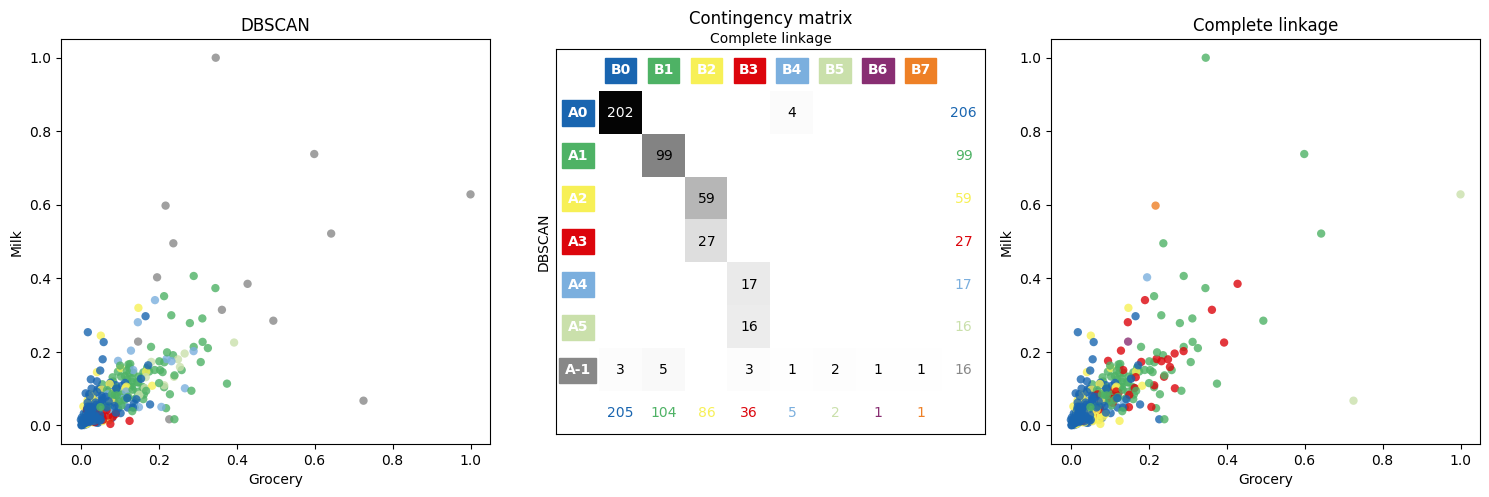

In [57]:
plot_contingency_matrix(clDBSn6v2_labels, clACn6v8_labels, "DBSCAN", "Complete linkage", Xn6v, vnames6v, vps["Grocery-Milk"])

Now, the clusterings of both algorithms are even more similar. For example, the DB Scan with epsilon 0.1 identified 9 points of  B2 as noise and the DB Scan with epsilon 0.2 doesn't identify any of them as noise.

In [58]:
metrics.rand_score(clDBSn6v2_labels, clACn6v8_labels), metrics.normalized_mutual_info_score(clDBSn6v2_labels, clACn6v8_labels)

(0.958790639884034, 0.8607031295883003)

This change made a big difference. Both values are now almost perfect, showing very high agreement between both clusterings.

Let's compare the results of this version of the DB Scan to the K-Means k = 8:

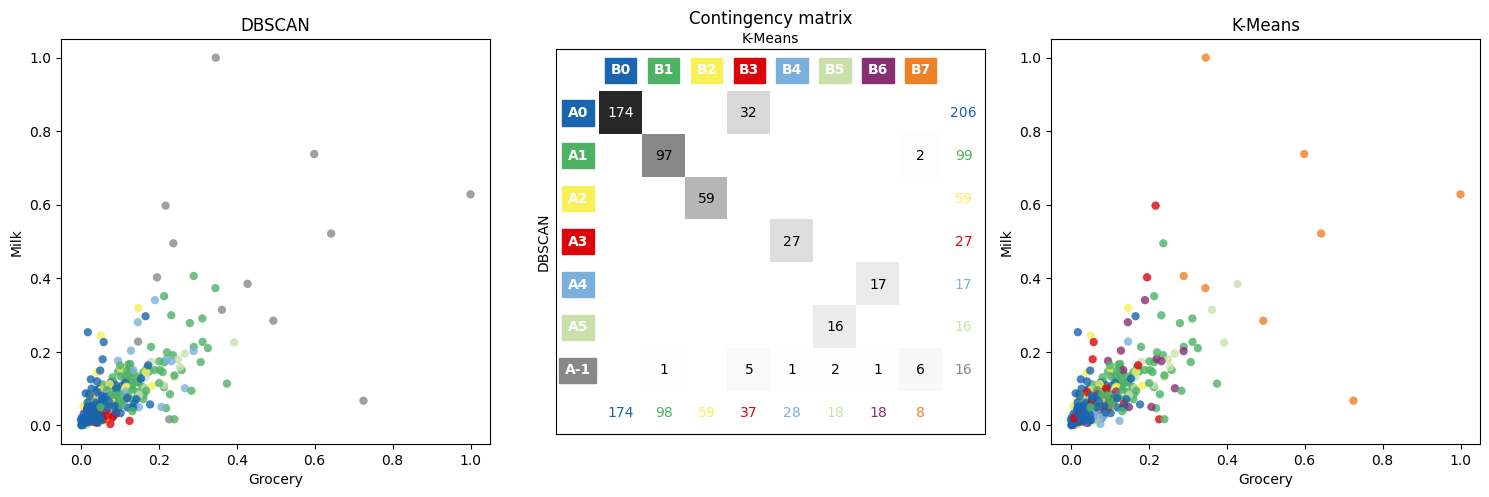

In [59]:
plot_contingency_matrix(clDBSn6v2_labels, clKMn6v8_labels, "DBSCAN", "K-Means", Xn6v, vnames6v, vps["Grocery-Milk"])

In [60]:
metrics.rand_score(clDBSn6v2_labels, clKMn6v8_labels), metrics.normalized_mutual_info_score(clDBSn6v2_labels, clKMn6v8_labels)

(0.9357941602816318, 0.8843946079441751)

Once again, we see that both algorithms have a very high agreement. The datapoints of Complete Linkage that were identified as noise by the DB Scan are not exactly the sames as the ones the DB Scan algorithm consideres to be noise in clustering of the K-Means algorithm. B0 of complete linkage, for example, has 3 data points that DB Scan identifies as noise, while the same cluster (B0) of K-Means contains no points that DB Scan identifies as noise. Also, the NMI and rand scores are very high again, showing once again, that all algorithms produce similar clusters. 

## Evaluation

Two metric will be used to do the evaluation of the different algorithms:
1) the intra-cluster to inter-cluster distance ratio: It describes the intrinsic quality of a clustering as it computes the ratio of the average of distances between pairs of point belonging to the same cluster to the average of distances between pairs belonging to different clusters. The smaller the value of this ratio, the more cohesive the clusters.

2) the silhouette score: It compares distances between points in the same cluster vs. in different clusters. This score takes values between -1 (worst) and 1 (optimal).

Both metrics are computed for each of the clustering algorithms and the resulting table is sorted by increasing distance ratio (from best to worst).

In [61]:
import scipy.spatial.distance as distance

v_dist6v = distance.pdist(Xn6v)

def intra_inter_distance_ratio(v_dist, clabels):
    Ct = numpy.tile(clabels, (len(clabels), 1))
    v_sameclass = distance.squareform((Ct == Ct.T) & (Ct != -1), checks=False)
    v_diffclass = distance.squareform((Ct != Ct.T) & (Ct != -1) & ( -1 != Ct.T), checks=False)
    return numpy.mean(v_dist[v_sameclass])/numpy.mean(v_dist[v_diffclass])

evl_series = [("KMeans (4)", clKMn6v4_labels),
              ("KMeans (8)", clKMn6v8_labels),
              ("Bisec.KMeans", clBKMn6v8_labels),
              ("Agg.Complete", clACn6v8_labels), 
              ("Agg.Single", clASn6v8_labels),  
              ("Agg.Ward", clAWn6v8_labels),  
              ("Agg.Average", clAAn6v8_labels), 
              ("DBSCAN", clDBSn6v_labels),
              ("DBSCAN with epsilon = 0.2", clDBSn6v2_labels)
              
             ]
evl_stats = [[mname, numpy.max(clbls)+1, -1 in clbls, 
                 metrics.silhouette_score(Xn6v, clbls), intra_inter_distance_ratio(v_dist6v, clbls)]
                for (mname, clbls) in evl_series]
internal_df = pandas.DataFrame(columns=["name", "nb_clusters", "outliers", "silhouette", "distance ratio"],
                             data = evl_stats)
internal_df.sort_values(by=["distance ratio"])

,name,nb_clusters,outliers,silhouette,distance ratio
7,DBSCAN,6,True,0.509885,0.146417
1,KMeans (8),8,False,0.585978,0.153686
2,Bisec.KMeans,8,False,0.585978,0.153686
5,Agg.Ward,8,False,0.530285,0.168711
8,DBSCAN with epsilon = 0.2,6,True,0.629961,0.171236
3,Agg.Complete,8,False,0.644156,0.193361
0,KMeans (4),4,False,0.679963,0.217219
6,Agg.Average,8,False,0.680581,0.229067
4,Agg.Single,8,False,0.544814,0.388032


When we look at this table, we see that only the K-Means k = 4 and DB Scan variants don't produce 8 clusters.

As the epsilon = 0.1 version of the DB Scan algorithm has a distance ratio of 0.15, it is on top of the displayed table. The other algorithms have very good performance too. The worst performer, Single Linkage, still has a distance ratio of 0.39, which is acceptable (but of course, not optimal).

We recompute the same table to order it descending according to the silhouette score, so it is easier to analyze these values in the correct order.

In [62]:
internal_df.sort_values(by=["silhouette"], ascending=False)

,name,nb_clusters,outliers,silhouette,distance ratio
6,Agg.Average,8,False,0.680581,0.229067
0,KMeans (4),4,False,0.679963,0.217219
3,Agg.Complete,8,False,0.644156,0.193361
8,DBSCAN with epsilon = 0.2,6,True,0.629961,0.171236
1,KMeans (8),8,False,0.585978,0.153686
2,Bisec.KMeans,8,False,0.585978,0.153686
4,Agg.Single,8,False,0.544814,0.388032
5,Agg.Ward,8,False,0.530285,0.168711
7,DBSCAN,6,True,0.509885,0.146417


Actually, we can see that this re-computation was really important. Because now we can easily see that there is a significant difference between the performance of our algorithms for both metrics. The ordering of the second table is almost the other way around from the first one. We can see again that it is extremly important to evaluate our algorithms across multiple metrics. Otherwise, we might wrongly "penelize" one algorithm (by not using it), becuase we think it is worse than others. It also helps us to understand the nature of the underlying dataset better. In this table, for example, we see that the average linkage has the best silhouette score, the K-means k = 4 and Complete linkage are top 2 and 3 respectively. Here, the DB Scan with epsilon = 0.1 is the worst performing algorithm according to the silhouette score.

Taken together, we could clearly see a few important things from this analysis: 
- we learned the importance of using different metrics to evaluate our algorithms
- we understood that playing around with different parameters for clustering algorithms can have a big effect on the end results
- all algorithms used in this specific analysis for clustering the Wholesale dataset had a good performance. Any of them would be a great choice to cluster the given dataset
